In [95]:
#Импорт необходимых библиотек
import re #Для работы с регулярными выражениями
import ast #Для десериализации признаков
import joblib
import pandas as pd #Для работы с данными
import numpy as np 
import sweetviz as sv #Для создания отчета по данным
import category_encoders as ce
import scipy.stats as stats #Для статистических тестов
from scipy.special import inv_boxcox
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn import feature_selection
from sklearn import metrics
import optuna
import xgboost as xgb
import catboost
#Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')

In [96]:
#Перед началом работы зафиксируйте случайность
random_seed = 42

# <center>**Итоговый проект первого года обучения</br>Агенство недвижимости**</center>

## Описание

К вам обратился представитель крупного агентства недвижимости со следующей проблемой:

*«Мои риелторы тратят катастрофически много времени на сортировку объявлений и поиск выгодных предложений. Поэтому их скорость реакции, да и, сказать по правде, качество анализа не дотягивают до уровня конкурентов. Это сказывается на наших финансовых показателях. Ваша задача — разработать модель, которая позволила бы обойти конкурентов по скорости и качеству совершения сделок. Вот датасет для работы»*

**Что необходимо сделать:** разработать сервис для предсказания стоимости домов на основе истории предложений.

Давайте определим этапы проекта:

1. **Знакомство с данными.** Посмотрим на наши данные, ознакомимся с признаками, воспользуемся библиотекой *dtale*, чтобы облегчить предобработку данных и определить проблемные места в данных.
2. **Предобработка данных** Приведем данные в *"порядок"*, очистим их от пропусков, выбросов и дубликатов.
3. **Разведовательный анализ данных** Займемся поиском закономерностей в данных, проведем статистические тесты и сделаем отбор признаков.
4. **Подготовка данных** Подготовим данные к подаче в модель.
5. **Построение модели** Построим baseline - линейная регрессия и решающее дерево, если мы поймемм, что задача решаема, то прибегнем к более сильным методам МО.
6. **Подготовка модели к прадеешену** Построение пайплайна

## **1. Знакомство с данными**

Прочитаем наши данные и посмотрим на получившуюся таблицу.

In [97]:
#Считываем данные
data = pd.read_csv('./data/data.csv')
#Выводим данные и информацию размерности таблицы
print(data.shape)
data.head()

(377185, 18)


status private pool        propertyType               street    baths  \
0    Active          NaN  Single Family Home       240 Heather Ln      3.5   
1  for sale          NaN  single-family home    12911 E Heroy Ave  3 Baths   
2  for sale          NaN  single-family home    2005 Westridge Rd  2 Baths   
3  for sale          NaN  single-family home  4311 Livingston Ave  8 Baths   
4  for sale          NaN            lot/land       1524 Kiscoe St      NaN   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...       yes   
3  {'atAGlanceFacts': [{'factValue': '2006', 'fac...       yes   
4  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   

             city                                            schools  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...   
2     Los Angeles  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...   
3          Dallas  [{'rating': ['9/10', '9/10', '10/10', '9/10'],...   
4        Palm Bay  [{'rating': ['4/10', '5/10', '5/10'], 'data': ...   

         sqft zipcode    beds state stories mls-id PrivatePool       MlsId  \
0        2900   28387       4    NC     NaN    NaN         NaN      611019   
1  1,947 sqft   99216  3 Beds    WA     2.0    NaN         NaN   201916904   
2  3,000 sqft   90049  3 Beds    CA     1.0    NaN         yes  FR19221027   
3  6,457 sqft   75205  5 Beds    TX     3.0    NaN         NaN    14191809   
4         NaN   32908     NaN    FL     NaN    NaN         NaN      861745   

       target  
0    $418,000  
1    $310,000  
2  $2,895,000  
3  $2,395,000  
4      $5,000

Признаки, которые есть в наших данных:

* **'status'** - статус продажи
* **'private pool'** и **'PrivatePool'** - наличие частного бассейна,
* **'propertyType'** - тип недвижимости, поместья, свойства,
* **'street'** - адрес дома
* **'baths'** - количество ванных комнат
* **'homeFacts'** - сведения о строении дома, содержит несколько отдельных данных, имеющих влияние на оценку недвижимости, дома, квартиры
* **'fireplace'** - сведения о наличии камина (ов) в доме
* **'city'** - город
* **'schools'** - сведения о школах в районе
* **'sqft'** - площадь дома в футах
* **'zipcode'** - почтовый индекс
* **'beds'** - количество спален в доме
* **'state'** - государство/штаты
* **'stories'** - этажность недвижимости
* **'mls-id'** и **'MlsId'** - идентификатор MLS (Multiple Listing Service - Служба множественного листинга)
* **'target'** - целевой признак, который необходимо спрогнозировать - цена недвижимости

Давайте сразу же удалим признаки, которые совсем не являются информативными или малоинформативны в контексте нашей задачи. Это признаки zipcode, а также schools, mls-id, MlsId(я посоветовался со своим знакомым риелтором, он сказал, что это мало влияет на цену недвижимости).

In [98]:
data = data.drop(['zipcode', 'mls-id', 'MlsId'], axis=1) #Удаляем малоинформативные признаки

В наших данных есть признак schools, который требует десериализации. Давайте создадим из него отдельную таблицу и посмотрим какие признаки могут нам пригодиться для решения нашей задачи.

In [99]:
def preprocessing_schools(schools):
    #Преобразуем строки, чтобы избавиться от ненужных элементов
    schools = schools.lower()
    schools = schools.replace('/10', '')
    schools = schools.replace('nr', 'None')
    schools = schools.replace('none', 'None')
    schools = schools.replace('na', 'None')
    schools = schools.replace(' mi', '')
    schools = schools.replace('mi', '')
    return schools

def deserialize_schools(data):
    data['schools'] = data['schools'].apply(preprocessing_schools)
    result_dict = {} #Словарь, из которого создадим таблицу
    X = data['schools'].apply(lambda x: ast.literal_eval(str(x))[0]).values #Получаем значения признака schools и производим десериализацию
    for features_list in X:
        #Для всех наблюдений 
        for feature, value in features_list.items():
            #Обращаемся ко всем признакам, которые содержатся в признаке schools
            #Если признак data, то обрабатываем его иначе.
            if 'data' == feature:
                for data_feature, data_value in value.items():
                    factLabel = data_feature
                    factValue = data_value
                    try:
                        #Добавляем значение признака в словарь
                        result_dict[factLabel].append(factValue)
                    except KeyError:
                        #Если признака еще не было в словаре, то добавляем его в словарь
                        result_dict[factLabel] = [factValue]
                #Переходим к следующему признаку
                continue
            else:
                factLabel = feature
                factValue = value
                try:
                    #Добавляем значение признака в словарь
                    result_dict[factLabel].append(factValue)
                except KeyError:
                    #Если признака еще не было в словаре, то добавляем его в словарь
                    result_dict[factLabel] = [factValue]
    #Формируем итоговый датафрейм и возвращаем полученную таблицу
    result_data = pd.DataFrame(result_dict)
    return result_data

schools_data = deserialize_schools(data)
print(schools_data.shape)
schools_data.head()

(377185, 4)


rating  \
0  [4, 4, 7, None, 4, 7, None, None]   
1                       [4, None, 4]   
2                          [8, 4, 8]   
3                      [9, 9, 10, 9]   
4                          [4, 5, 5]   

                                     distance  \
0  [2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]   
1                          [1.65, 1.32, 1.01]   
2                          [1.19, 2.06, 2.63]   
3                     [1.05, 0.1, 1.05, 0.81]   
4                          [5.96, 3.25, 3.03]   

                                          grades  \
0  [3–5, 6–8, 9–12, pk–2, 6–8, 9–12, pk–5, k–12]   
1                              [9-12, 3-8, pk-8]   
2                               [6-8, k-5, 9-12]   
3                         [5-6, pk-4, 7-8, 9-12]   
4                              [7-8, 9-12, pk-6]   

                                              Noneme  
0  [southern pines elementary school, southernddl...  
1  [east valley high school&extension, eastvalley...  
2  [paul revereddle school, brentwood science sch...  
3  [mcculloch intermediate school, bradfield elem...  
4  [southwestddle school, bayside high school, we...

Я не хочу использовать эти признаки в чистом виде, поэтому создадим из них новые: средний рейтинг, среднее расстояние.

In [100]:
def get_schools_features(schools_data):
    #проходим по нужным признакам
    for feature in ['rating', 'distance']:
        #Список для результатов
        result = []
        #Иттерируемся по каждой строке
        for row in schools_data[feature]:
            mean = 0
            counter = 0
            #Для каждого значения из списка
            for value in row:
                #Если значение пропуск, то пропускаем иттерацию
                if value == 'None' or value == '':
                    continue
                #Считаем среднее
                mean += float(value)
                counter += 1
            #Добавляем нужно значение в список результата
            if counter == 0:
                result.append(None)
            else:
                mean /= counter
                result.append(mean)
        #Создаем новый признак с помощью полученных данных
        schools_data[f'avg_{feature}_schools'] = result
            
    return schools_data

schools_data = get_schools_features(schools_data)
schools_data.head()


rating  \
0  [4, 4, 7, None, 4, 7, None, None]   
1                       [4, None, 4]   
2                          [8, 4, 8]   
3                      [9, 9, 10, 9]   
4                          [4, 5, 5]   

                                     distance  \
0  [2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]   
1                          [1.65, 1.32, 1.01]   
2                          [1.19, 2.06, 2.63]   
3                     [1.05, 0.1, 1.05, 0.81]   
4                          [5.96, 3.25, 3.03]   

                                          grades  \
0  [3–5, 6–8, 9–12, pk–2, 6–8, 9–12, pk–5, k–12]   
1                              [9-12, 3-8, pk-8]   
2                               [6-8, k-5, 9-12]   
3                         [5-6, pk-4, 7-8, 9-12]   
4                              [7-8, 9-12, pk-6]   

                                              Noneme  avg_rating_schools  \
0  [southern pines elementary school, southernddl...            5.200000   
1  [east valley high school&extension, eastvalley...            4.000000   
2  [paul revereddle school, brentwood science sch...            6.666667   
3  [mcculloch intermediate school, bradfield elem...            9.250000   
4  [southwestddle school, bayside high school, we...            4.666667   

   avg_distance_schools  
0              5.537500  
1              1.326667  
2              1.960000  
3              0.752500  
4              4.080000

Удаляем из таблицы ненужные признаки и присоединяем ее к нашим основным данным.

In [101]:
#Выбираем признаки, которые хотим добавить
schools_data = schools_data[['avg_rating_schools', 'avg_distance_schools']]

#Добавляем новые признаки и удаляем признак homeFacts
new_cols = schools_data.columns
data[new_cols] = schools_data
data = data.drop('schools', axis=1)
print(data.shape)
data.head()

(377185, 16)


status private pool        propertyType               street    baths  \
0    Active          NaN  Single Family Home       240 Heather Ln      3.5   
1  for sale          NaN  single-family home    12911 E Heroy Ave  3 Baths   
2  for sale          NaN  single-family home    2005 Westridge Rd  2 Baths   
3  for sale          NaN  single-family home  4311 Livingston Ave  8 Baths   
4  for sale          NaN            lot/land       1524 Kiscoe St      NaN   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...       yes   
3  {'atAGlanceFacts': [{'factValue': '2006', 'fac...       yes   
4  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   

             city        sqft    beds state stories PrivatePool      target  \
0  Southern Pines        2900       4    NC     NaN         NaN    $418,000   
1  Spokane Valley  1,947 sqft  3 Beds    WA     2.0         NaN    $310,000   
2     Los Angeles  3,000 sqft  3 Beds    CA     1.0         yes  $2,895,000   
3          Dallas  6,457 sqft  5 Beds    TX     3.0         NaN  $2,395,000   
4        Palm Bay         NaN     NaN    FL     NaN         NaN      $5,000   

   avg_rating_schools  avg_distance_schools  
0            5.200000              5.537500  
1            4.000000              1.326667  
2            6.666667              1.960000  
3            9.250000              0.752500  
4            4.666667              4.080000

В наших данных есть признак homeFacts, который требует десериализации. Давайте создадим из него отдельную таблицу и посмотрим какие признаки могут нам пригодиться для решения нашей задачи.

In [102]:
def preprocessing_homeFacts(home_facts):
    # Make the string lowercase
    home_facts = home_facts.lower()
    home_facts = home_facts.replace('none', 'None')
    # Remove commas between digits
    home_facts = re.sub(r'(\d),(\d)', r'\1\2', home_facts)
    # Remove the '$' symbol
    home_facts = home_facts.replace('$', '')
    # Remove the ' sqft', ' sq. ft.', and ' acres' strings
    home_facts = home_facts.replace(' sqft', '')
    home_facts = home_facts.replace('/sqft', '')
    home_facts = home_facts.replace(' sq. ft.', '')
    # Remove the ' lot', ' acre', and 'contact manager' strings
    home_facts = home_facts.replace(' lot', '')
    home_facts = home_facts.replace('contact manager', '')
    # Remove the ' /', '—', '-' and 'no info' strings
    home_facts = home_facts.replace('—', '')
    home_facts = home_facts.replace('-', '')
    home_facts = home_facts.replace(' /', '')
    home_facts = home_facts.replace('no info', '')
    return home_facts

def deserialize_homeFacts(data):
    """Функция производит десериализацию признака homeFacts и возвращает данные, полученные из этого признака.

    Args:
        data (pandas.core.frame.DataFrame): Датафрейм с нашими данными

    Returns:
        pandas.core.frame.DataFrame: Таблица полученная из признака homeFacts
    """
    #Преобразуем данные
    data['homeFacts'] = data['homeFacts'].apply(preprocessing_homeFacts)
    result_dict = {} #Словарь, из которого создадим таблицу
    X = data['homeFacts'].apply(lambda x: ast.literal_eval(str(x))['ataglancefacts']).values #Получаем значения признака homeFacts и производим десериализацию
    for features_list in X:
        #Для всех наблюдений 
        for feature in features_list:
            #Обращаемся ко всем признакам, которые содержатся в признаке homeFacts
            factLabel = feature['factlabel']
            factValue = feature['factvalue']
            try:
                #Добавляем значение признака в словарь
                result_dict[factLabel].append(factValue)
            except KeyError:
                #Если признака еще не было в словаре, то добавляем его в словарь
                result_dict[factLabel] = [factValue]
    #Формируем итоговый датафрейм и возвращаем полученную таблицу
    result_data = pd.DataFrame(result_dict)
    return result_data
    
homeFacts_data = deserialize_homeFacts(data)
print(homeFacts_data.shape)
homeFacts_data.head()

(377185, 7)


year built remodeled year                 heating  cooling          parking  \
0       2019                 central a/c, heat pump                             
1       2019                                                                    
2       1961           1967              forced air  central  attached garage   
3       2006           2006              forced air  central  detached garage   
4                                                                               

  lotsize price  
0    None   144  
1    5828   159  
2    8626   965  
3    8220   371  
4   10019  None

Я оставлю все признаки, кроме Price/sqft, так как этот признак может создать утечку данных, потому что содержит информацию о ценообразовании.

In [103]:
#Удаляем признак, который может вызывать утечку данных
homeFacts_data = homeFacts_data.drop('price', axis=1)
print(homeFacts_data.shape)

(377185, 6)


Теперь избавимся от скрытых пропусков в полученных данных и приведем их к нужным типам.

In [104]:
def del_hidden_na(x):
    #Функция избавляется от скрытых пропусков в наших данных
    if x is None or x == 'no data' or x == '':
        x = None
    return x
        
def preprocess_lotsize(x):
    #Переводим акры в футы, если это необходимо
    if x is None:
        return None
    if 'acre' in x or 'acres' in x:
        x = x.replace(' acres', '')
        x = x.replace(' acre', '')
        x = float(x)       
        x = x * 43600
    else:
        x = float(x)
    return x

#Приводи данные к нужному типу и избавляемся от скрытых пропусков
cols = homeFacts_data.columns
for col in cols:
    homeFacts_data[col] = homeFacts_data[col].apply(del_hidden_na)
    if col == 'year built' or col == 'remodeled year':
        homeFacts_data[col] = homeFacts_data[col].apply(lambda x: int(x) if not x is None else None)
    elif col == 'lotsize':
        homeFacts_data[col] = homeFacts_data[col].apply(preprocess_lotsize)
        
homeFacts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year built      313589 non-null  float64
 1   remodeled year  151075 non-null  float64
 2   heating         259208 non-null  object 
 3   cooling         242564 non-null  object 
 4   parking         188431 non-null  object 
 5   lotsize         281330 non-null  float64
dtypes: float64(3), object(3)
memory usage: 17.3+ MB


Присоединяем полученную таблицу к нашим данным.

In [105]:
#Добавляем новые колонки и удаляем признак homeFacts
new_cols = homeFacts_data.columns
data[new_cols] = homeFacts_data
data = data.drop('homeFacts', axis=1)
print(data.shape)
data.head()

(377185, 21)


status private pool        propertyType               street    baths  \
0    Active          NaN  Single Family Home       240 Heather Ln      3.5   
1  for sale          NaN  single-family home    12911 E Heroy Ave  3 Baths   
2  for sale          NaN  single-family home    2005 Westridge Rd  2 Baths   
3  for sale          NaN  single-family home  4311 Livingston Ave  8 Baths   
4  for sale          NaN            lot/land       1524 Kiscoe St      NaN   

  fireplace            city        sqft    beds state  ... PrivatePool  \
0  Gas Logs  Southern Pines        2900       4    NC  ...         NaN   
1       NaN  Spokane Valley  1,947 sqft  3 Beds    WA  ...         NaN   
2       yes     Los Angeles  3,000 sqft  3 Beds    CA  ...         yes   
3       yes          Dallas  6,457 sqft  5 Beds    TX  ...         NaN   
4       NaN        Palm Bay         NaN     NaN    FL  ...         NaN   

       target avg_rating_schools  avg_distance_schools  year built  \
0    $418,000           5.200000              5.537500      2019.0   
1    $310,000           4.000000              1.326667      2019.0   
2  $2,895,000           6.666667              1.960000      1961.0   
3  $2,395,000           9.250000              0.752500      2006.0   
4      $5,000           4.666667              4.080000         NaN   

   remodeled year                 heating  cooling          parking  lotsize  
0             NaN  central a/c, heat pump     None             None      NaN  
1             NaN                    None     None             None   5828.0  
2          1967.0              forced air  central  attached garage   8626.0  
3          2006.0              forced air  central  detached garage   8220.0  
4             NaN                    None     None             None  10019.0  

[5 rows x 21 columns]

Выведем основную информацию по нашим данным.

In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                337267 non-null  object 
 1   private pool          4181 non-null    object 
 2   propertyType          342452 non-null  object 
 3   street                377183 non-null  object 
 4   baths                 270847 non-null  object 
 5   fireplace             103114 non-null  object 
 6   city                  377151 non-null  object 
 7   sqft                  336608 non-null  object 
 8   beds                  285903 non-null  object 
 9   state                 377185 non-null  object 
 10  stories               226469 non-null  object 
 11  PrivatePool           40311 non-null   object 
 12  target                374704 non-null  object 
 13  avg_rating_schools    372033 non-null  float64
 14  avg_distance_schools  372901 non-null  float64
 15  

Теперь давайте посмотрим на наши данные более подробно с помощью библиотеки dtale.

In [107]:
#report = sv.analyze(data)
#report.show_html()

На самом деле просмотрев отчет можно сделать очень много выводов. Сразу становится понятно, что наши данные очень грязные, кучу не соответствий переменных своим типам, пропуски, очевидные выбросы дублированные значения внутри признаков и прочее, со всем этим надо разбираться, поэтому перейдем к следующему этапу нашего проекта, предобработка данных.

## **2. Анализ и Предобработка данных**

Как я уже сказал, в наших данных большое количество проблем и с ними нужно бороться. Давайте будем идти последовательно по каждому признаку, чтобы ничего не пропустить, и приводить данные в порядок.

In [108]:
data_cleaned = data.copy() #Создадим копию данных для удобства

Также реализуем функцию, которую будем использовать для очистки данных от выбросов. Я отдам предпочтение методу Тьюки.

In [109]:
def tukey_method(data, feature, right=1.5, left=1.5, log_need=False):
    """Функция для удаления выбросов с помощью метода Тьюки

    Args:
        data (pandas.core.frame.DataFrame): Датафрейм с нашими данными
        feature (str): Признак, который мы хотим очистить
        right (float, optional): Для усов в право. Defaults to 1.5.
        left (float, optional): Длина усов в лево. Defaults to 1.5.
        log_need (bool, optional): Индикато, который отвечает за логарифмирование данных. Defaults to False.
    """
    if log_need: #Логарифмируем данные, если требуется
        X = np.log(data[feature] + 1)
    else:
        X = data[feature]
    #Рассчитываем квантили
    quantile_1 = X.quantile(0.25)
    quantile_2 = X.quantile(0.75)
    #Считаем межквартильный размах
    iqr = quantile_2 - quantile_1
    #Находим верхнюю и нижнюю границы
    lower_bound = quantile_1 - left * iqr
    upper_bound = quantile_2 + right * iqr
    #Очищаем данные
    data_cleaned = data[(X >= lower_bound) & (X <= upper_bound)]
    return data_cleaned

Давайте посмотрим на наличие пропусков в наших данных.

In [110]:
#Выводим проценты пропусков в столбцах
data_cleaned.isnull().mean() * 100

status                  10.583136
private pool            98.891525
propertyType             9.208479
street                   0.000530
baths                   28.192532
fireplace               72.662221
city                     0.009014
sqft                    10.757851
beds                    24.200856
state                    0.000000
stories                 39.958111
PrivatePool             89.312672
target                   0.657767
avg_rating_schools       1.365908
avg_distance_schools     1.135782
year built              16.860692
remodeled year          59.946711
heating                 31.278285
cooling                 35.690974
parking                 50.042817
lotsize                 25.413259
dtype: float64

Можно заметить, что пропусков большое количество, будем обраюатывать их постепенно вместе с признаками.

Теперь посмотрим на то, сколько дубликатов в наших данных и при их наличии удалим их.

In [111]:
print(f'Количество дубликатов: {data_cleaned.duplicated().sum()}')
data_cleaned = data_cleaned.drop_duplicates()
print(f'Количество дубликатов после удаления: {data_cleaned.duplicated().sum()}')

Количество дубликатов: 143
Количество дубликатов после удаления: 0


Начнем с целевой переменной. Она должна быть числовым типом, а у нас она имеет тип object это связано с тем, что в данных есть строковые знаки, а также некоторые цены рассчитаны с расчетом на месяц, такие наблюдения имеют значение признака status = 'for rent' их всего 398, поэтому просто удалим их. Но для начала удалим все наблюдения, в которых есть пропуск в целевой переменной.

In [112]:
# Удаляем пропуски в целевой переменной
data_cleaned.dropna(subset=['target'], inplace=True)
#Удаляем наблюдения, которые рассчитаны на аренду
data_cleaned = data_cleaned[data_cleaned['status'] != 'for rent']
data_cleaned.shape

(374164, 21)

Теперь напишем функцию, которая приведет целевой признак к числовому типу.

In [113]:
def preprocessing_target(x):
    #Избавляемся от ненужных знаков и преводим к нужному типу
    x = str(x)
    x = x.replace(',', '')
    x = x.replace('$', '')
    x = x.replace('+', '')
    x = float(x)
    return x

data_cleaned['target'] = data_cleaned['target'].apply(preprocessing_target)
data_cleaned['target'].describe()

count    3.741640e+05
mean     6.454484e+05
std      1.842247e+06
min      1.000000e+00
25%      1.879000e+05
50%      3.200000e+05
75%      5.847785e+05
max      1.950000e+08
Name: target, dtype: float64

Итак, целевая переменная имеет очень большой разброс значений, давайте посмотрим на распределение этого признака.

Text(0.5, 1.0, 'Распределение целевой переменной')

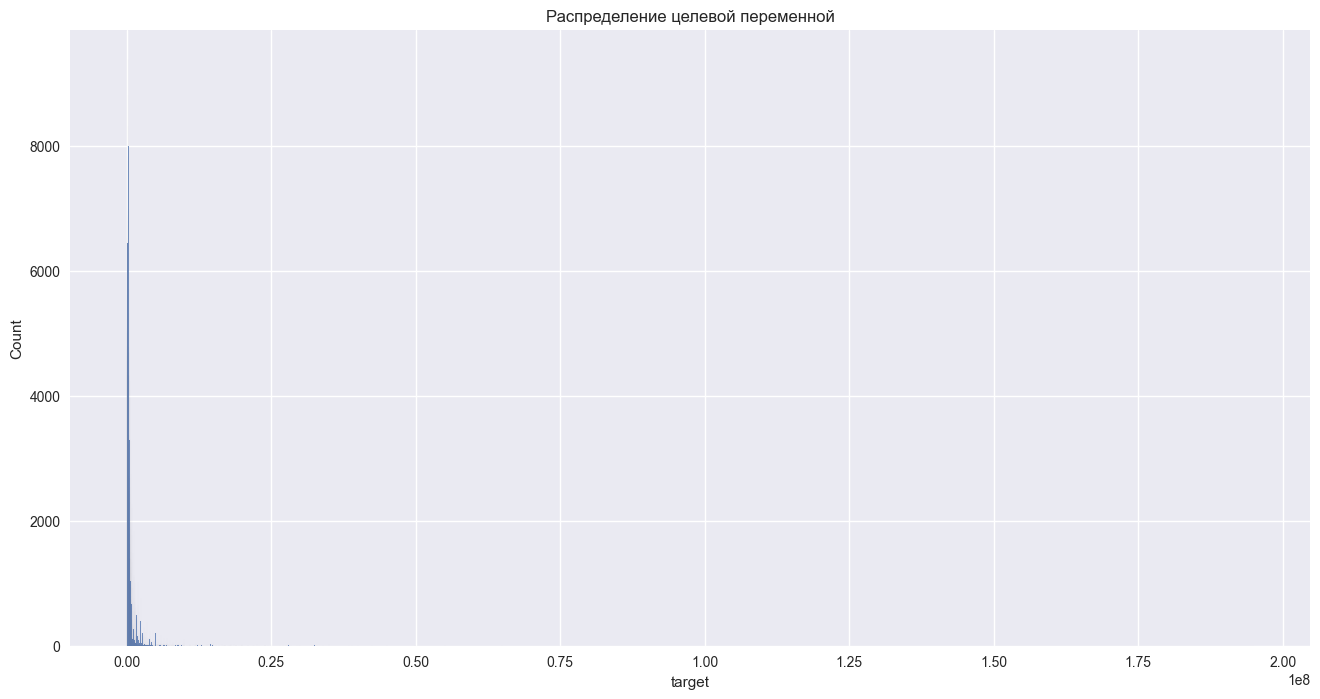

In [114]:
#Визуализируем гистограмму целевой переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data_cleaned, x='target', ax=ax)
ax.set_title('Распределение целевой переменной')

Проверим целевой признак на нормальность, используя тест Шапиро-Уилка.

In [115]:
alpha = 0.05
# проводим тест Шапиро — Уилка
_, p = stats.shapiro(data_cleaned['target']);
print('p-value = %.3f' % (p))
# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

p-value = 0.000
Распределение не нормальное


C:\Users\drfre\AppData\Local\Temp\ipykernel_27980\691605052.py:3: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 374164.
  _, p = stats.shapiro(data_cleaned['target']);


Из графика становится явно, что такой разброс обусловлен выбросными значениями, удалим их используя метод Тьюки, предварительно создав признак применив boxcox преобразование к целевой переменной, чтобы распределение стало похоже на нормальное, так как данные имеют очень большой разброс, то будем предсказывать именного его.

In [116]:
# Применяем преобразование Бокса-Кокса к целевой переменной
update_price = stats.boxcox(data_cleaned['target'])
# Применяем наши изменения для целевой переменной
data_cleaned['target_boxcox'] = update_price[0]

Text(0.5, 1.0, 'Распределение boxcox преобразования целевой переменной')

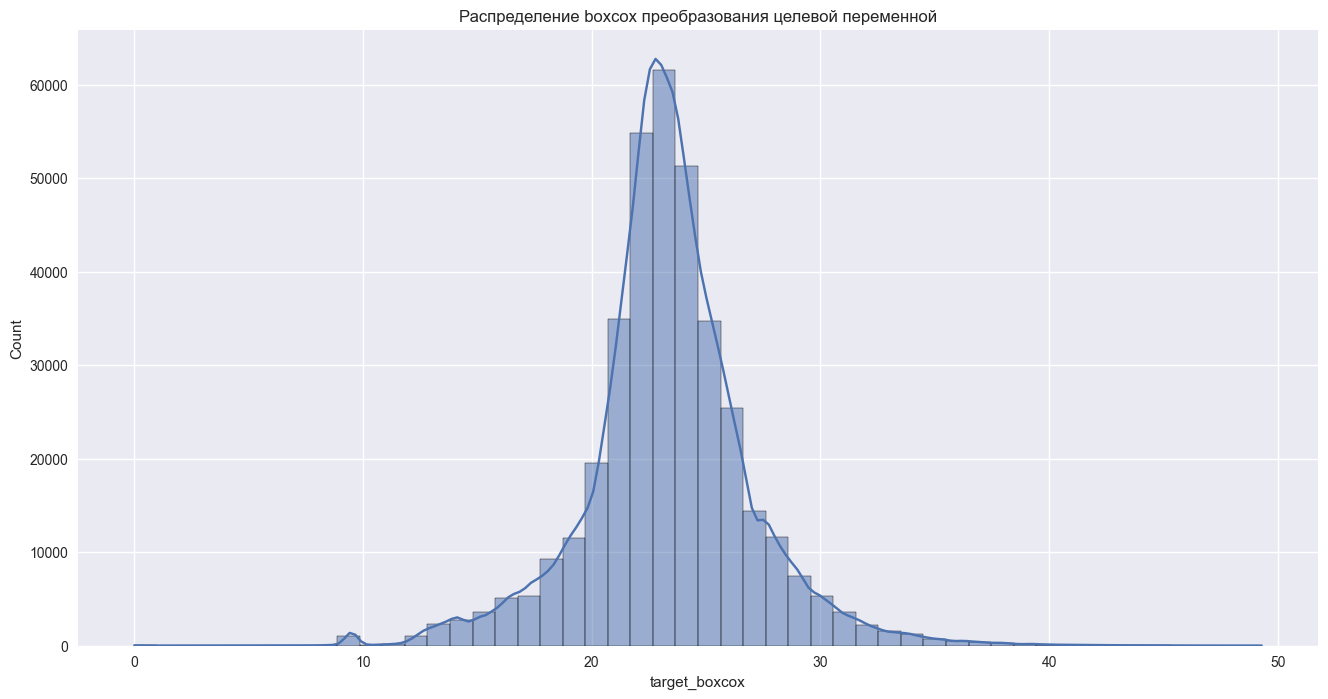

In [117]:

#Визуализируем гистограмму преобразования целевой переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data_cleaned, x='target_boxcox', bins=50, kde=True, ax=ax)
ax.set_title('Распределение boxcox преобразования целевой переменной')

Посмотрим теперь на основные характеристики целевой переменной.

In [118]:
data_cleaned['target'].describe()

count    3.741640e+05
mean     6.454484e+05
std      1.842247e+06
min      1.000000e+00
25%      1.879000e+05
50%      3.200000e+05
75%      5.847785e+05
max      1.950000e+08
Name: target, dtype: float64

Количество наблюдений после удаления выбросов: 336170


Text(0.5, 1.0, 'Распределение целевой переменной')

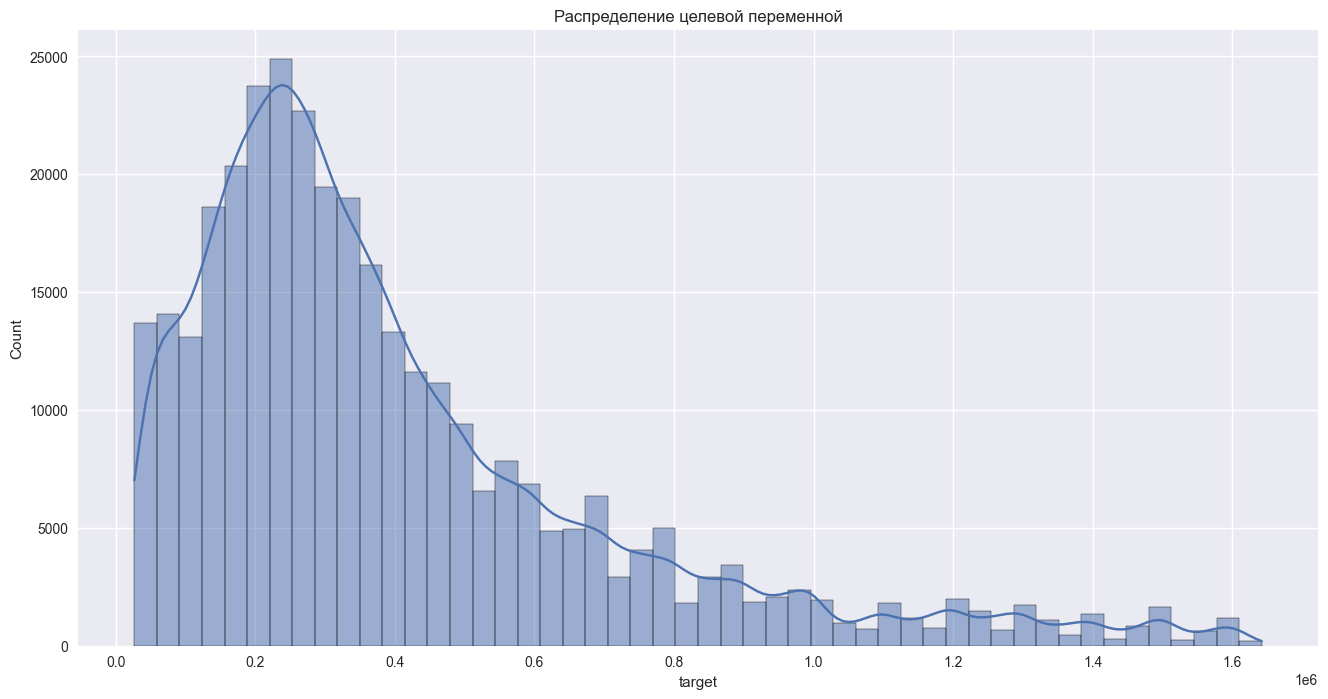

In [119]:
#Удаляем выбросы
data_cleaned = tukey_method(data_cleaned, 'target_boxcox', right=1)
print(f'Количество наблюдений после удаления выбросов: {data_cleaned.shape[0]}')

#Визуализируем гистограмму целевой переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data_cleaned, x='target', bins=50, kde=True, ax=ax)
ax.set_title('Распределение целевой переменной')

Далее предобработаем признак, который соответствует площади дома в футах, для начала приведем его к нужному типу данных, для этого избавимся от скрытых пропусков и ненужных символов.

In [120]:
def sqft_preprocessing(x):
    #Избавляемся от ненужных символов
    x = str(x)
    x = x.replace(',', '')
    #Достаем нужное значение
    x = re.search(r'\d*', x).group(0)
    if x:
        return float(x)
    else:
        return None
    
data_cleaned['sqft'] = data_cleaned['sqft'].apply(sqft_preprocessing)
#Избавляемся от пропусков, заполняя их медианным значением
print('Процент пропусков в признаке sqft: {}'.format(round(data_cleaned['sqft'].isnull().mean() * 100, 2)))
data_cleaned['sqft'] = data_cleaned['sqft'].fillna(data_cleaned['sqft'].median())
data_cleaned['sqft'].describe()

Процент пропусков в признаке sqft: 15.58


count    3.361700e+05
mean     6.322816e+03
std      1.582873e+06
min      0.000000e+00
25%      1.327000e+03
50%      1.760000e+03
75%      2.304000e+03
max      7.959794e+08
Name: sqft, dtype: float64

Странным является то, что площадь может быть нулевой, давайте посмотрим, сколько таких наблюдений.

In [121]:
data_cleaned[data_cleaned['sqft'] == 0]['sqft'].count()

7446

Больше 7000 зданий, площадь у которых равна нулю, удалим их.

In [122]:
data_cleaned = data_cleaned[data_cleaned['sqft'] > 100]

Text(0.5, 1.0, 'Распределение признака sqft')

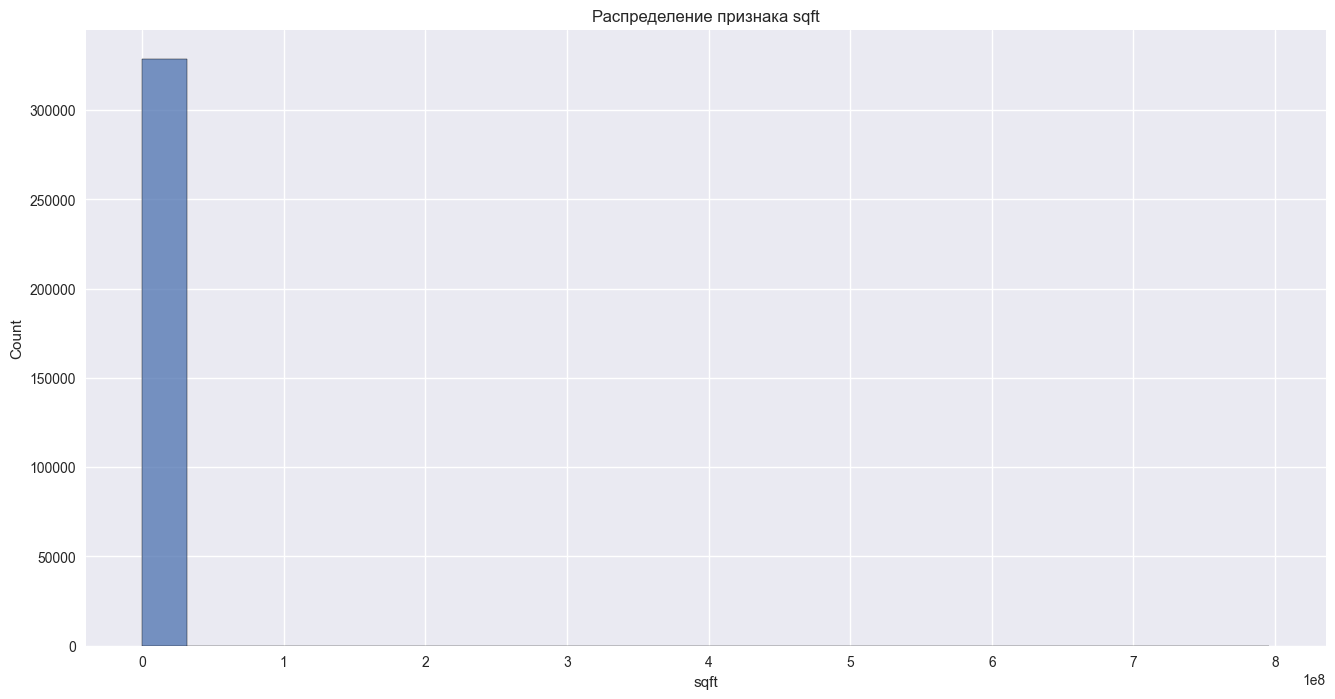

In [123]:
#Визуализируем гистограмму признака
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data_cleaned, x='sqft', bins=25, ax=ax)
ax.set_title('Распределение признака sqft')

Очевидным является наличие выбросов - слишком большие значения для площади, удалим наблюдения, для которых значение sqft больше 6000.

Количество наблюдений до удаления выбросов: 328618
Количество наблюдений после удаления выбросов: 325353


Text(0.5, 1.0, 'Распределение признака sqft')

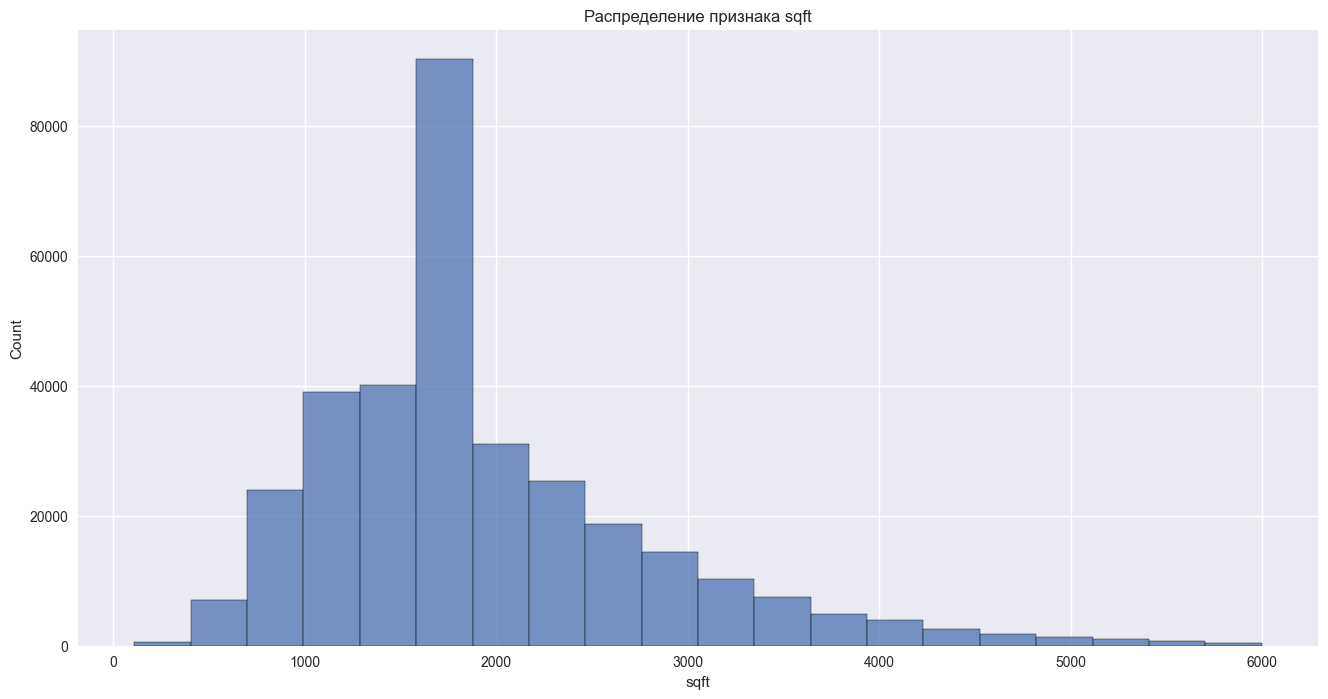

In [124]:
#Очищаем данные
print(f'Количество наблюдений до удаления выбросов: {data_cleaned.shape[0]}')
#Создаем маску для удаления выбросов
mask = ~(data_cleaned['sqft'] >= 6000)
data_cleaned = data_cleaned[mask]
print(f'Количество наблюдений после удаления выбросов: {data_cleaned.shape[0]}')

#Визуализируем гистограмму логарифма целевой переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data_cleaned, x='sqft', bins=20, ax=ax)
ax.set_title('Распределение признака sqft')

В наших данных есть признак lotsize - площадь всего участка. Он может быть полезным, давайте заполним пропуски в нем следующим образом: если значение отсутствует, то заполним его значением площади здания.

In [125]:
#Пройдемся по каждой строке и заполним пропуски
for i, row in data_cleaned.iterrows():
    x = row['lotsize']
    if str(x) == 'nan':
        data_cleaned.at[i, 'lotsize'] = row['sqft']

print('Количество пропусков в признаке lotsize: {}'.format(data_cleaned['lotsize'].isnull().sum()))

Количество пропусков в признаке lotsize: 0


Посмотрим на зависимость площади постройки от площади участка.

Text(0.5, 1.0, 'Зависимость площади постройки от площади участка')

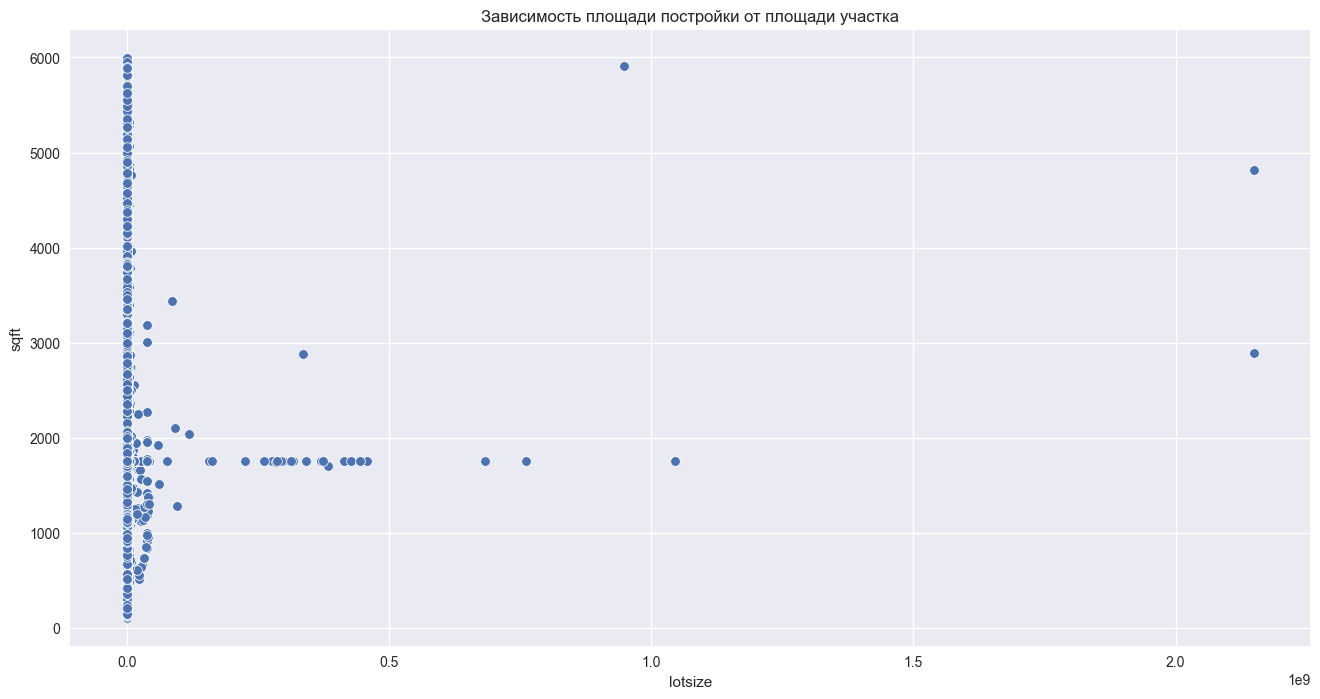

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.scatterplot(data_cleaned, x='lotsize', y='sqft', ax=ax)
ax.set_title('Зависимость площади постройки от площади участка')

Видим, что в признаке lotsize есть очень большие значения, давайте удалим все значения, которые больше 50000. Также удалим наблюдения, у которых значение площади участка равно нулю.

Data shape: (310058, 22)


Text(0.5, 1.0, 'Зависимость площади постройки от площади участка')

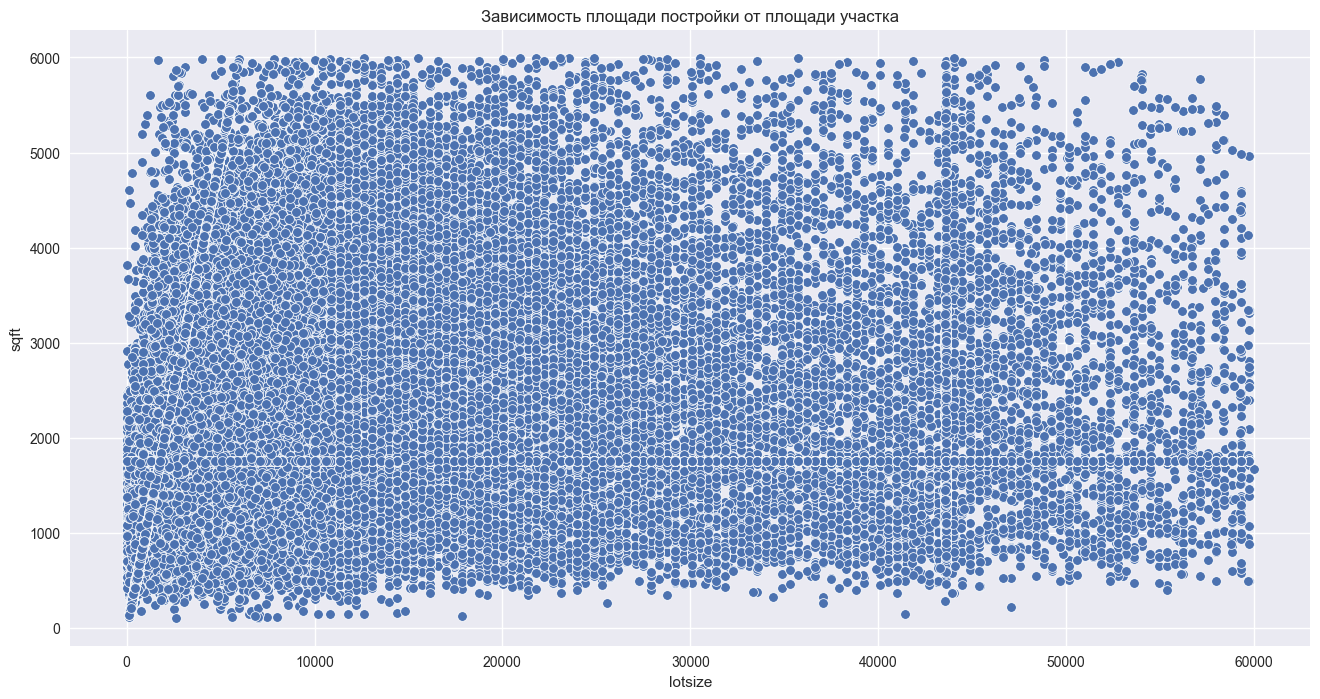

In [127]:
#Удаляем слишком большие значения
mask = data_cleaned['lotsize'] <= 60000
data_cleaned = data_cleaned[mask]
#Удаляем слишком маленькие значения
mask = data_cleaned['lotsize'] > 0
data_cleaned = data_cleaned[mask]

print(f'Data shape: {data_cleaned.shape}')
#Посмотрим на график теперь
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.scatterplot(data_cleaned, x='lotsize', y='sqft', ax=ax)
ax.set_title('Зависимость площади постройки от площади участка')

Удалим наблюдения, у которых площадь постройки больше площади участка.

Data shape: (293673, 22)


Text(0.5, 1.0, 'Зависимость площади постройки от площади участка')

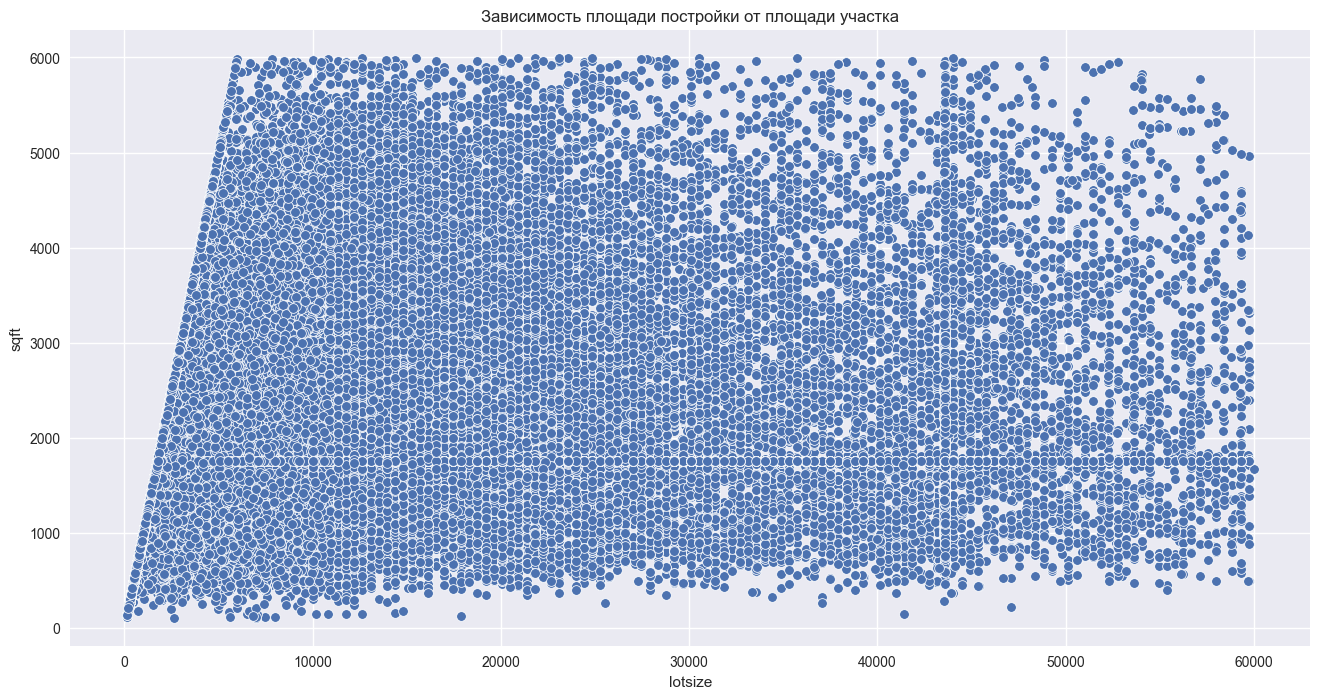

In [128]:
mask = data_cleaned['lotsize'] >= data_cleaned['sqft']
data_cleaned = data_cleaned[mask]
print(f'Data shape: {data_cleaned.shape}')

#Посмотрим на график теперь
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.scatterplot(data_cleaned, x='lotsize', y='sqft', ax=ax)
ax.set_title('Зависимость площади постройки от площади участка')

Из графика видно, что зависимость между признаками отсутствует. Удалим выбросы в этом признаке.

Количество наблюдений после удаления выбросов: 293660


Text(0.5, 1.0, 'Распределение  lotsize')

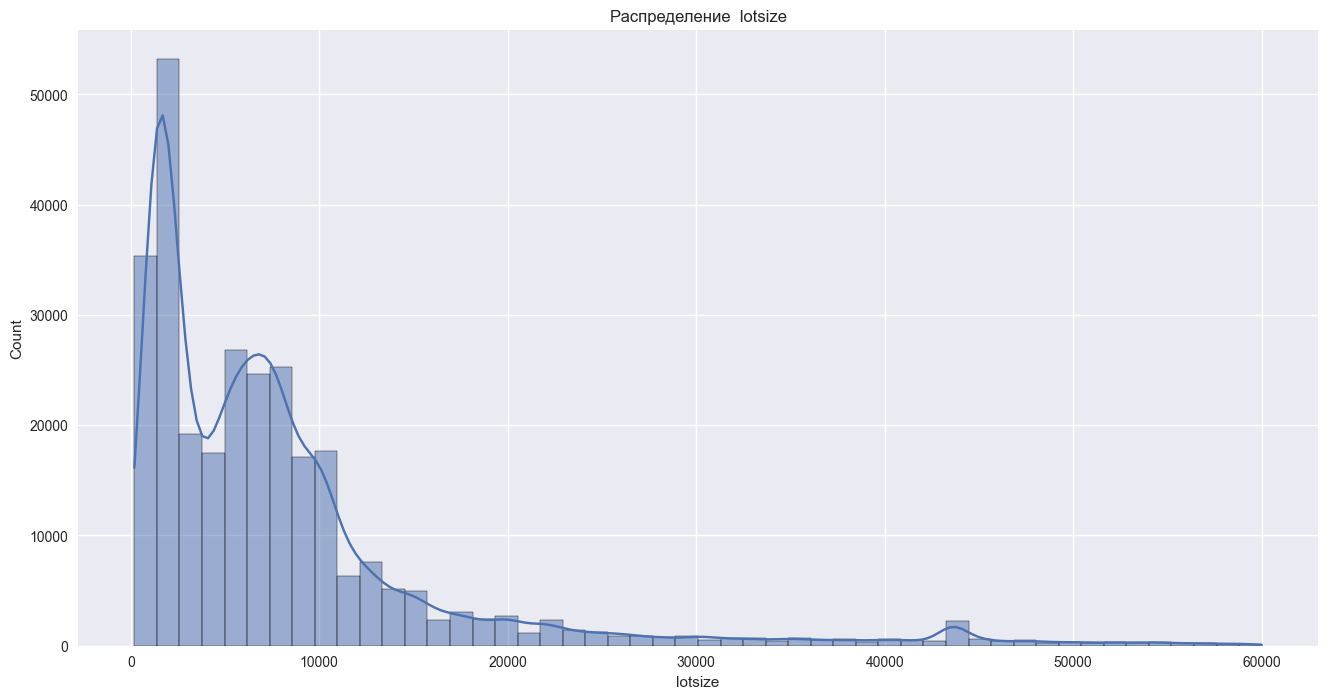

In [129]:
#Удаляем выбросы
data_cleaned = tukey_method(data_cleaned, 'lotsize', log_need=True)
print(f'Количество наблюдений после удаления выбросов: {data_cleaned.shape[0]}')

#Визуализируем гистограмму целевой переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data_cleaned, x='lotsize', bins=50, kde=True, ax=ax)
ax.set_title('Распределение  lotsize')

Перейдем к следующему признаку PrivatePool. В наших данных два столбца, которые соответствуют этому признаку, давайте объединим их значения в один. Также в признаках много пропусков и нет ни одного значение, которое бы соответствовало отсутствию бассейна, поэтому вместо пропусков будем считать, что бассейна нет.

In [130]:
def preprocessing_PrivatePool(data):
    #Функция предобработки признака наличия бассейна
    cols = ['PrivatePool', 'private pool'] #Названия столбцов, которые надо предобработать
    for col in cols:
        #Заменяем значения столбцов
        data[col] = data[col].apply(lambda x: 1 if (x == 'yes') or (x == 'Yes') else 0)
    #Объединям столбцы в один
    data['pool'] = (data[cols[0]] + data[cols[1]]).apply(lambda x: 1 if x > 0 else 0)
    data = data.drop(cols, axis=1)
    return data

data_cleaned = preprocessing_PrivatePool(data_cleaned)
print(f'Shape of data: {data_cleaned.shape}')
data_cleaned['pool'].value_counts(normalize=True)

Shape of data: (293660, 21)


pool
0    0.886941
1    0.113059
Name: proportion, dtype: float64

Теперь предобработаем признак baths. Он также должен быть целочисленным типом. 

In [131]:
def preprocessing_baths(x):
    #Приводим к нижнему регистру
    x = str(x).lower()
    #Убираем лишние символы и слова
    x = x.replace(' ba', '')
    x = x.replace('bathrooms: ', '')
    x = x.replace(' baths', '')
    x = x.replace('ths', '')
    x = x.replace('sq. ft. ', '')
    x = x.replace('semimod', '')
    x = x.replace('—', '')
    x = x.replace(' / ', '')
    x = x.replace('--', '')
    x = x.replace('~', '')
    x = x.replace('+', '')
    x = x.replace(',', '')
    if '-' in x:
        x = None
    elif x:
        x = float(x)
    else:
        x = None
    return x

data_cleaned['baths'] = data_cleaned['baths'].apply(preprocessing_baths)
data_cleaned['baths'].value_counts()    

baths
2.0       91430
3.0       56113
4.0       19295
1.0       14511
2.5       11577
          ...  
1111.0        1
22.0          1
27.0          1
19.0          1
18.0          1
Name: count, Length: 65, dtype: int64

Перед дальнейшими преобразованиями заполним пропуски модальным значением.

In [132]:
#Заполняем пропуски
data_cleaned['baths'] = data_cleaned['baths'].fillna(data_cleaned['baths'].mode()[0])

Итак, после преобразования признакак становится ясно, что присутствуют аномальные значения, например, не целое количество ванных комнат или очень большое количество. Давайте удалим все наблюдения, где ванных комнат больше 7, а где их не целое количество округлим в меньшую сторону.

In [133]:
#Создаем маску дляя удаления аномальных значение
mask = data_cleaned['baths'] <= 7
data_cleaned = data_cleaned[mask]
#Приводим все значения к целому числу
data_cleaned['baths'] = data_cleaned['baths'].apply(lambda x: int(x))
print(f'Shape of data: {data_cleaned.shape}')

Shape of data: (280251, 21)


Text(0.5, 1.0, 'Распределение признака baths')

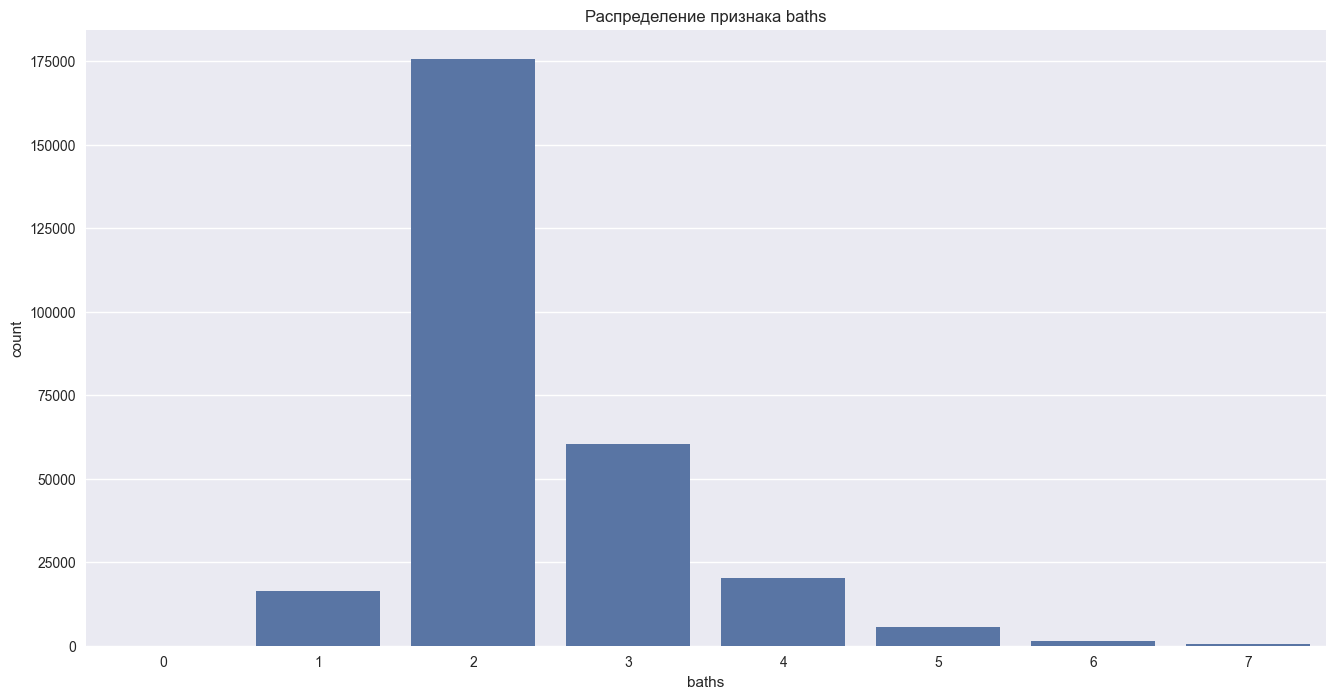

In [134]:
#Визуализируем  распределение признака
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data=data_cleaned, x='baths', ax=ax)
ax.set_title('Распределение признака baths')

Теперь преобразуем признак beds. С ним ситуация похожая с baths.

In [135]:
def preprocessing_baths(x):
    #Приводим к нижнему регистру
    x = str(x).lower()
    #Отмечаем как пропуски значения, которые указаны некоректно
    if 'ba' in x:
        return None
    elif 'acr' in x:
        return None
    elif 'sq' in x:
        return None
    elif 'or more bed' in x:
        return float(x.split()[0])
    elif '#' in x:
        return None
    else: #Удаляем ненужные слова и символы
        x = x.replace(' beds', '')
        x = x.replace(' bd', '')
        x = x.replace('--', '')
        x = x.replace(' ', '')
        x = x.replace(',', '')
        if x:
            return float(x)
        else:
            return None
        
data_cleaned['beds'] = data_cleaned['beds'].apply(preprocessing_baths)

Посмотрим на то, сколько пропусков в этом признаке.

In [136]:
#Считаем процент пропущенных значений
data_cleaned['beds'].isnull().mean() * 100

22.04737895672094

Заполним эти пропуски модальным значением.

In [137]:
#Заполняем пропуски
data_cleaned['beds'] = data_cleaned['beds'].fillna(data_cleaned['beds'].mode()[0])

Удаляем все наблюдения, у которых больше 7 спален.

In [138]:
#Избавляемся от выбросов
mask = data_cleaned['beds'] <= 7
data_cleaned = data_cleaned[mask]
print(f'Shape of data: {data_cleaned.shape}')

Shape of data: (279313, 21)


Выведем распределение признака beds.

Text(0.5, 1.0, 'Распределение признака beds')

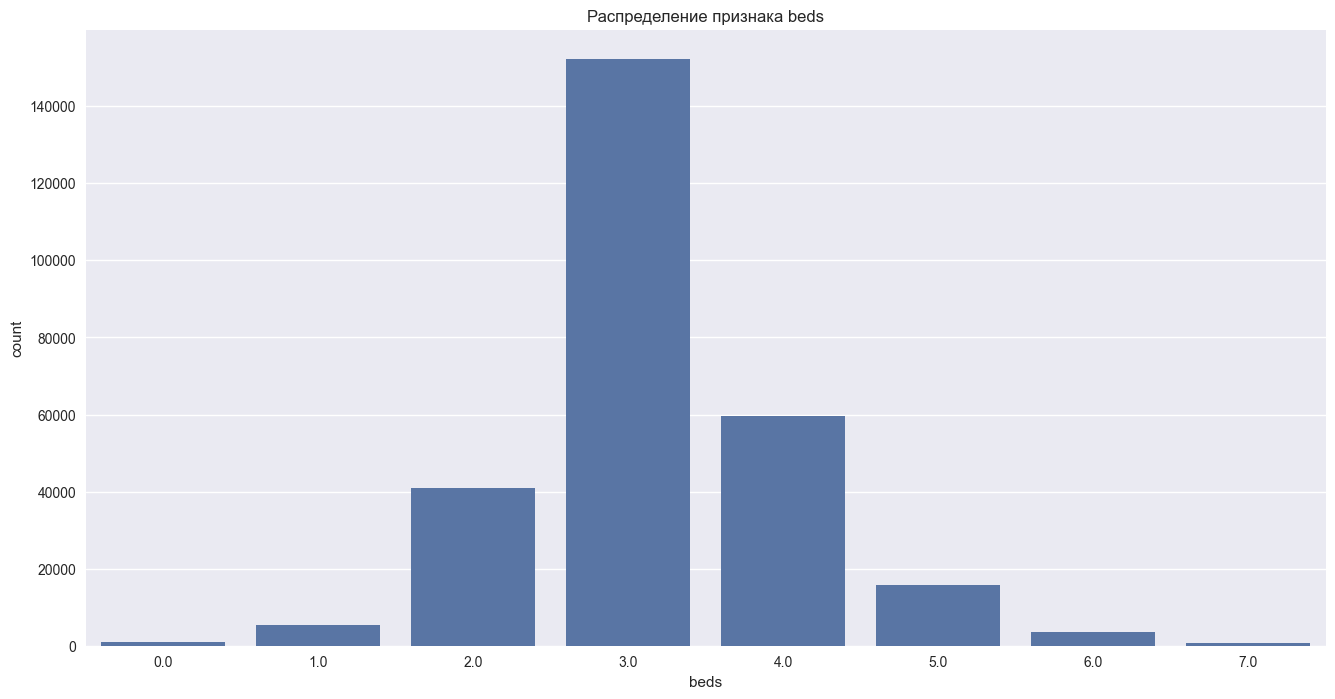

In [139]:
#Визуализируем  распределение признака
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data=data_cleaned, x='beds', ax=ax)
ax.set_title('Распределение признака beds')

Следующим шагом подготовим признак year built. Посмотрим на его статистические характеристики.

In [140]:
data_cleaned['year built'].describe()

count    2.440710e+05
mean     4.590732e+06
std      1.603012e+09
min      1.057000e+03
25%      1.958000e+03
50%      1.985000e+03
75%      2.007000e+03
max      5.599906e+11
Name: year built, dtype: float64

Сначала заполним пропуски модальным значением.

In [141]:
data_cleaned['year built'] = data_cleaned['year built'].fillna(data_cleaned['year built'].mode()[0])

Оставим значения, которые входят в диапазон от 1900 до 2023.

In [142]:
#Избавляемся от выбросов
mask = (data_cleaned['year built'] >= 1900) & (data_cleaned['year built'] <= 2023)
data_cleaned = data_cleaned[mask]
print(f'Shape of data: {data_cleaned.shape}')

Shape of data: (277079, 21)


Посмотрим на итоговое распределение признака.

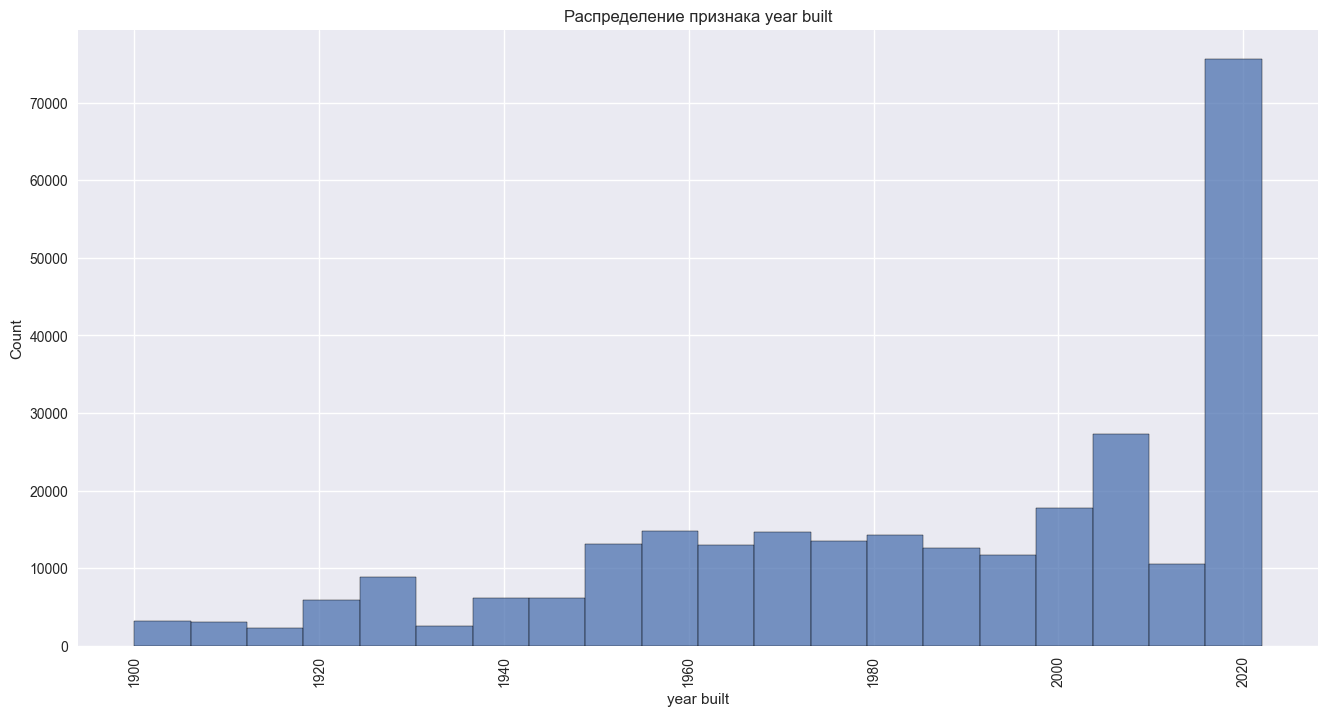

In [143]:
#Визуализируем  распределение признака
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data_cleaned, x='year built', bins=20, ax=ax)
ax.set_title('Распределение признака year built')
ax.xaxis.set_tick_params(rotation=90)

Давайте из года постройки создадим признак возраста постройки.

In [144]:
data_cleaned['built_age'] = 2024 - data_cleaned['year built']

Также у нас в данных есть год реконструкции здания, в нем много пропусков, но мы будем считать, что пропущенное значение означает о том, что реконструкция не производилась. Давайте с помощью этого признака создадим новый, который будет соответствовать количеству лет с последней реконструкции, но перед этим создадим признак индикатор is_remodeled, он будет принимать значения 1 - реконструкция была и 0 - не было. Затем удалим признаки year built и remodeled year, так как они нам больше не понадобятся. 

In [145]:
def repair_age_add(data):
    #Функция добавляет признак возраста ремонта
    for i, row in data.iterrows(): #Итерируемся по всем наблюдениям
        if np.isnan(data.at[i, 'remodeled year']): #Если год реконструкции отсутствует, то возраст ремонта равен возрасту постройки
            data.at[i, 'repair_age'] = data.at[i, 'built_age']
        else: #Иначе считаем возраст постройки
            data.at[i, 'repair_age'] = 2024 - data.at[i, 'remodeled year']
    return data

#Генерируем признак индикатор
data_cleaned['is_remodeled'] = data_cleaned['remodeled year'].apply(lambda x: 1 if not np.isnan(x) else 0)
#Генерируем новый признак
data_cleaned = repair_age_add(data_cleaned)
#Удаляем признаки, которые нам больше не нужны
data_cleaned = data_cleaned.drop(['year built', 'remodeled year'], axis=1)
#Посмотрим основные статистики
data_cleaned['repair_age'].describe()

count    277079.000000
mean         36.123929
std          59.228150
min           2.000000
25%           7.000000
50%          26.000000
75%          54.000000
max        2024.000000
Name: repair_age, dtype: float64

Теперь удалим элементы, у которых полученный возраст ремонта больше, чем возраст постройки.

In [146]:
#Избавляемся от выбросов
mask = (data_cleaned['built_age'] - data_cleaned['repair_age']) >= 0
data_cleaned = data_cleaned[mask]
print(f'Shape of data: {data_cleaned.shape}')

Shape of data: (274479, 22)


Давайте посмотрим на распределения полученных признаков.

Text(0.5, 1.0, 'Распределение признака is_remodeled')

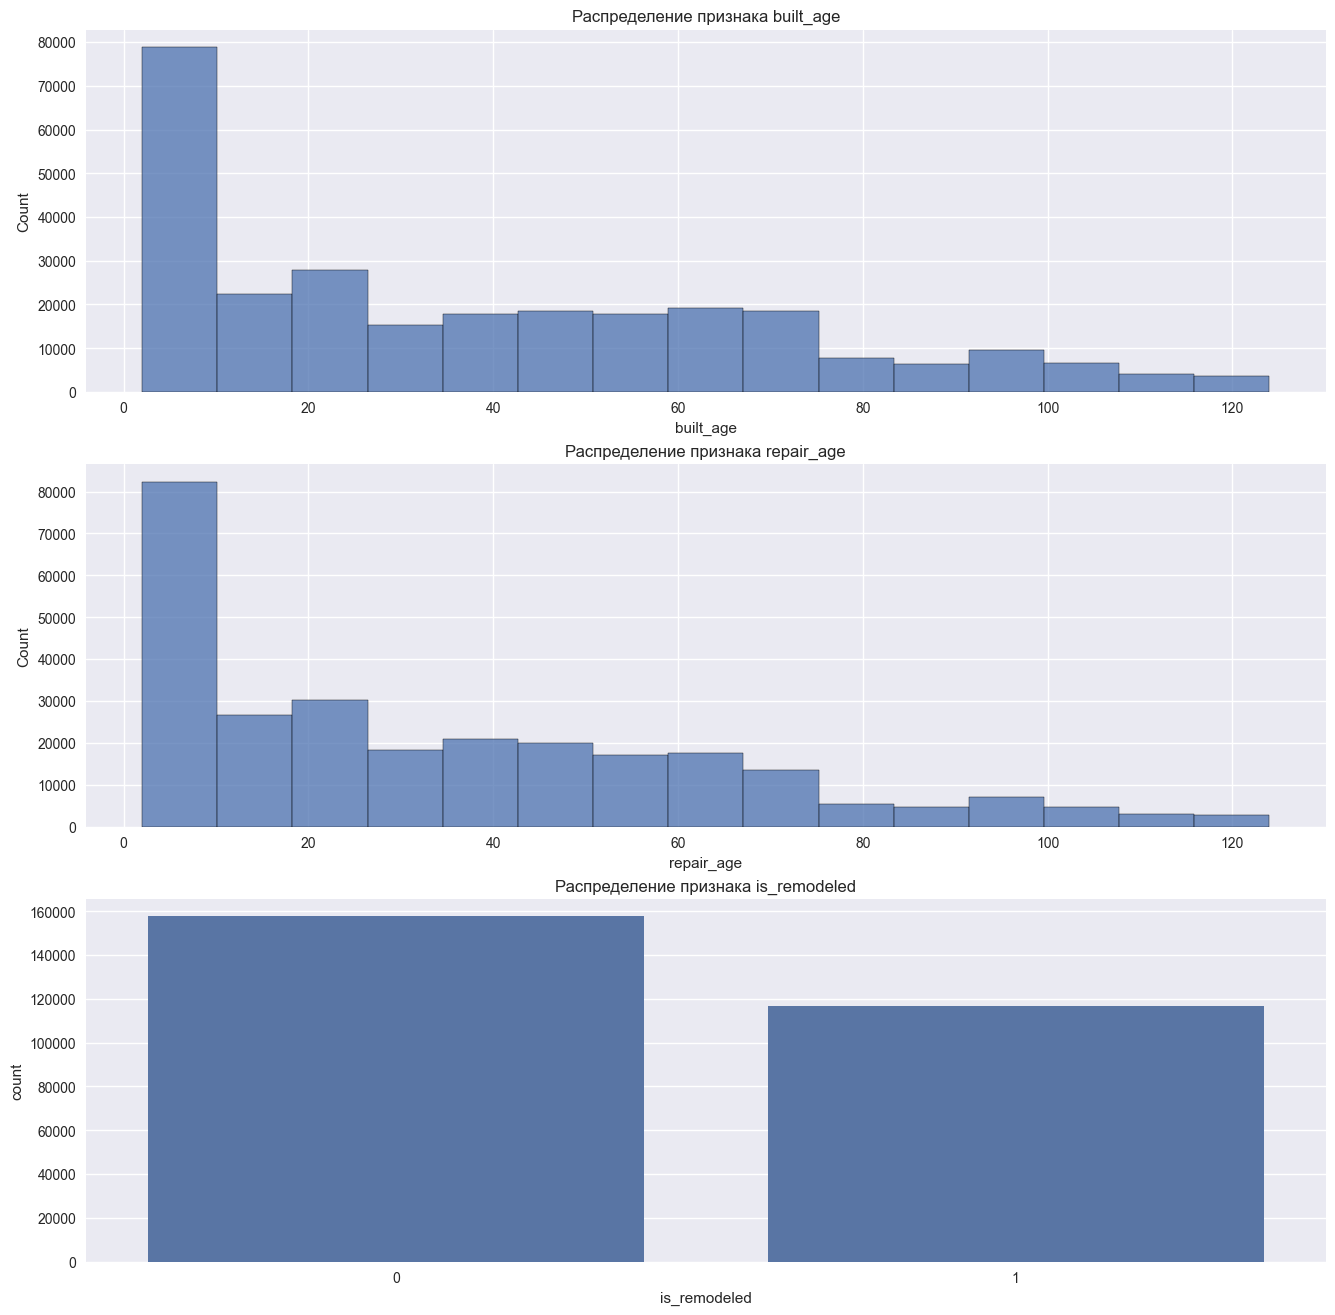

In [147]:
#Визуализируем распределения признаков
fig, axes = plt.subplots(3, 1, figsize=(16, 16))
#Построили первый график
sns.histplot(data=data_cleaned, x='built_age', bins=15, ax=axes[0])
axes[0].set_title('Распределение признака built_age')
#Построили второй график
sns.histplot(data=data_cleaned, x='repair_age', bins=15, ax=axes[1])
axes[1].set_title('Распределение признака repair_age')
#Построили третий график
sns.countplot(data=data_cleaned, x='is_remodeled', ax=axes[2])
axes[2].set_title('Распределение признака is_remodeled')

Видим сильную схожесть распределений, можно предположить, что реконструкция чаще всего либо не производилась, либо производилась вскоре после постройки недвижимости. Такая схожесть распределений наталкивает на мысль о том, что эти признаки могут вызывать мультиколлинеарность.

Следующим предобработаем признак города. У него есть немного пропусков, заполним их модальным значением. И оставим только 10 наиболее популярных городов, остальные пометим как 'other'. Также поступим с признаком state.

In [148]:
#Заполняем пропуски в признаке city
data_cleaned['city'] = data_cleaned['city'].fillna(data_cleaned['city'].mode()[0])
#Предобрабатываем признак city
top_city = data_cleaned['city'].value_counts().head(10).index
data_cleaned['city'] = data_cleaned['city'].apply(lambda x: x if x in top_city else 'other')

#Предобрабатываем признак state
top_states = data_cleaned['state'].value_counts().head(10).index
data_cleaned['state'] = data_cleaned['state'].apply(lambda x: x if x in top_states else 'other')

Давайте отобразим получившиеся распределения признаков.

Text(0.5, 1.0, 'Распределение признака state')

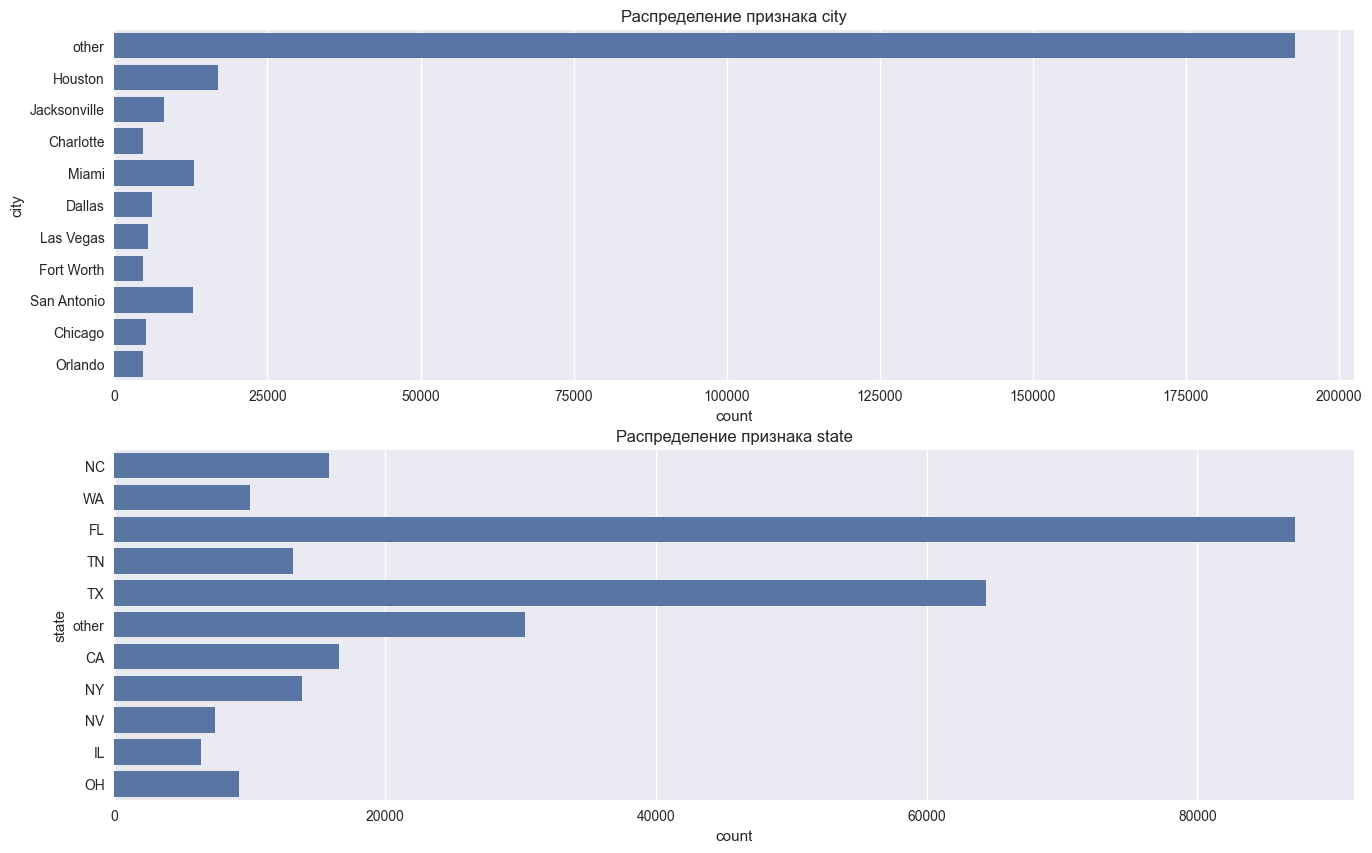

In [149]:
#Визуализируем распределения признаков
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Построили первый график
sns.countplot(data=data_cleaned, y='city', ax=axes[0])
axes[0].set_title('Распределение признака city')
#Построили второй график
sns.countplot(data=data_cleaned, y='state', ax=axes[1])
axes[1].set_title('Распределение признака state')

Разберемся с признаком адреса. Сам по себе он является бесполезным, потому что каждый дом обладает уникальнам адресом, но из него можно попробовать достать какую-то информацию. Давайте создадим из признака адрес признак с типом улицы.

Text(0.5, 1.0, 'Распределение признака street_type')

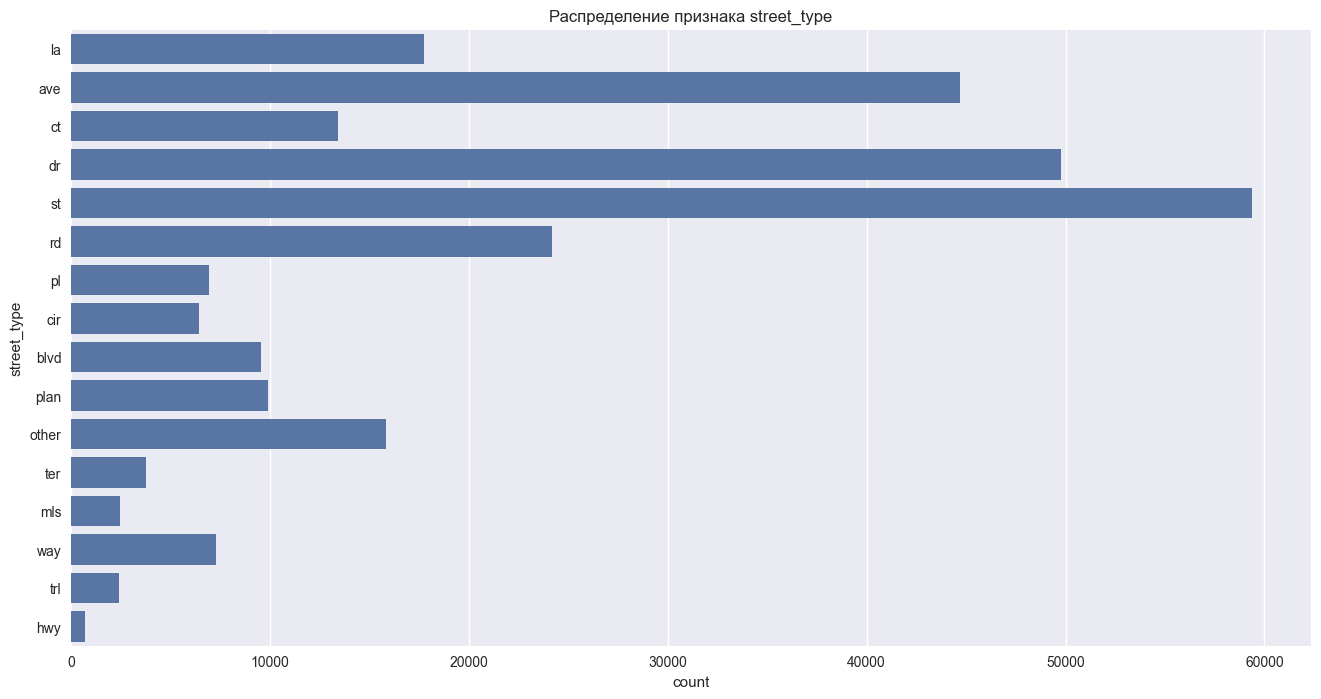

In [150]:
def get_street_type(street):
    street = str(street)
    #Приводим строку к нижнему регистру
    street = street.lower()
    #Удаляем ненужные символы
    street = re.sub(r'\d+', '', street)
    street = street.replace(',', '')
    street = street.replace('(', '')
    street = street.replace(')', '')
    street = street.replace(':', '')
    street = street.replace('.', '')
    #Разбиваем адресс на слова
    street_list = street.split()
    #Определяем самые популярные типы улиц
    if 'road' in street_list or 'rd' in street_list:
        return 'rd'
    elif 'street' in street_list or 'st' in street_list:
        return 'st'
    elif 'avenue' in street_list or 'ave' in street_list:
        return 'ave'
    elif 'boulevard' in street_list or 'blvd' in street_list:
        return 'blvd'
    elif 'way' in street_list:
        return 'way'
    elif 'lane' in street_list or 'la' in street_list or 'ln' in street_list:
        return 'la'
    elif 'drive' in street_list or 'dr' in street_list:
        return 'dr'
    elif 'terrace' in street_list or 'ter' in street_list:
        return 'ter'
    elif 'place' in street_list or 'pl' in street_list:
        return 'pl'
    elif 'court' in street_list or 'ct' in street_list:
        return 'ct'
    elif 'highway' in street_list or 'hwy' in street_list:
        return 'hwy'
    elif 'beltway' in street_list or 'bltwy' in street_list:
        return 'bltwy'
    elif 'circle' in street_list or 'cir' in street_list:
        return 'cir'
    elif 'mls' in street_list:
        return 'mls'
    elif 'trl' in street_list:
        return 'trl'
    elif 'plan' in street_list:
        return 'plan'
    elif 'address' in street_list:
        return None
    else:
        return 'other'

data_cleaned['street_type'] = data_cleaned['street'].apply(get_street_type)
data_cleaned['street_type'] = data_cleaned['street_type'].fillna(data_cleaned['street_type'].mode()[0])
data_cleaned = data_cleaned.drop('street', axis=1)

#Визуализируем  распределение признака
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data=data_cleaned, y='street_type', ax=ax)
ax.set_title('Распределение признака street_type')

Давайте разберемся с оставшимеся признаками status и propertyType.

In [151]:
def preprocessing_status(status):
    # Создаём списки топ слов 
    # остальные пометим как other 
    for_sale = ['for']
    active = ['active', 'a', 'active/contingent']
    fore_closure = ['foreclosure', 'auction', 'foreclosed', 'pre-foreclosure']
    pending = ['p', 'pending']
    contract = ['under', 'c']
    new = ['new']
    back_change = ['back','change']
    rent = ['rent']
    coming_soon = ['coming']
    # Приведем все символы к нижнему регистру
    # Разобьём на списки слов 
    splitted_st = status.lower().split(' ')

    for i in splitted_st:
        if i in active:
            return 'active'
        elif i in for_sale:
            return 'for sale'
        elif i in fore_closure:
            return 'foreclosure'
        elif i in pending:
            return 'pending'
        elif i in new:
            return 'new'
        elif i in back_change:
            return 'back changes'
        elif i in rent:
            return 'rent'
        elif i in contract: 
            return 'contract'
        elif i in coming_soon: 
            return 'coming soon'
    
    return 'other'

#Преобразовываем признак
data_cleaned['status'] = data_cleaned['status'].astype(str).apply(preprocessing_status)
data_cleaned['status'].value_counts()

status
for sale        153392
active           63985
other            34875
foreclosure       8820
pending           5425
new               5006
contract          2493
back changes       393
coming soon         90
Name: count, dtype: int64

In [152]:
def preprocessing_type(type):
    # Создаём списки топ слов 
    # остальные пометим как other 
    single_family = [
        'single',
        'townhouse',
        'ranch',
        'traditional',
        'detached',
        'colonial',
        'contemporary'
    ]
    multi_family = ['multi', 'coop', 'condo','high','apartment']
    mobile = ['mobile']
    bungalow = ['bungalow']
    
    # Приведем все символы к нижнему регистру
    # Разобьём на списки слов 
    splitted_st = type.lower().split(' ')

    for i in splitted_st:
        if i in single_family:
            return 'single family home'
        elif i in multi_family:
            return 'multi family'
        elif i in mobile:
            return 'mobile'
        elif i in bungalow:
            return 'bungalow'
    
    return 'other'

# Уберём лишнее: запятые, тире, слеши
data_cleaned['propertyType'] = data_cleaned['propertyType'].replace('[/,\\-,\s]', ' ', regex=True)
# Удаляем строки, в которых в столбце propertyType встречается слово land, они отвечают за пустой участок
data_cleaned = data_cleaned[~data_cleaned['propertyType'].str.contains('land', case=False, na=False)]
data_cleaned['propertyType'] = data_cleaned['propertyType'].astype(str).apply(preprocessing_type)
data_cleaned['propertyType'].value_counts()

propertyType
single family home    181946
multi family           51574
other                  27643
mobile                  2685
bungalow                 477
Name: count, dtype: int64

Отобразим распределения полученных признаков.

Text(0.5, 1.0, 'Распределение признака propertyType')

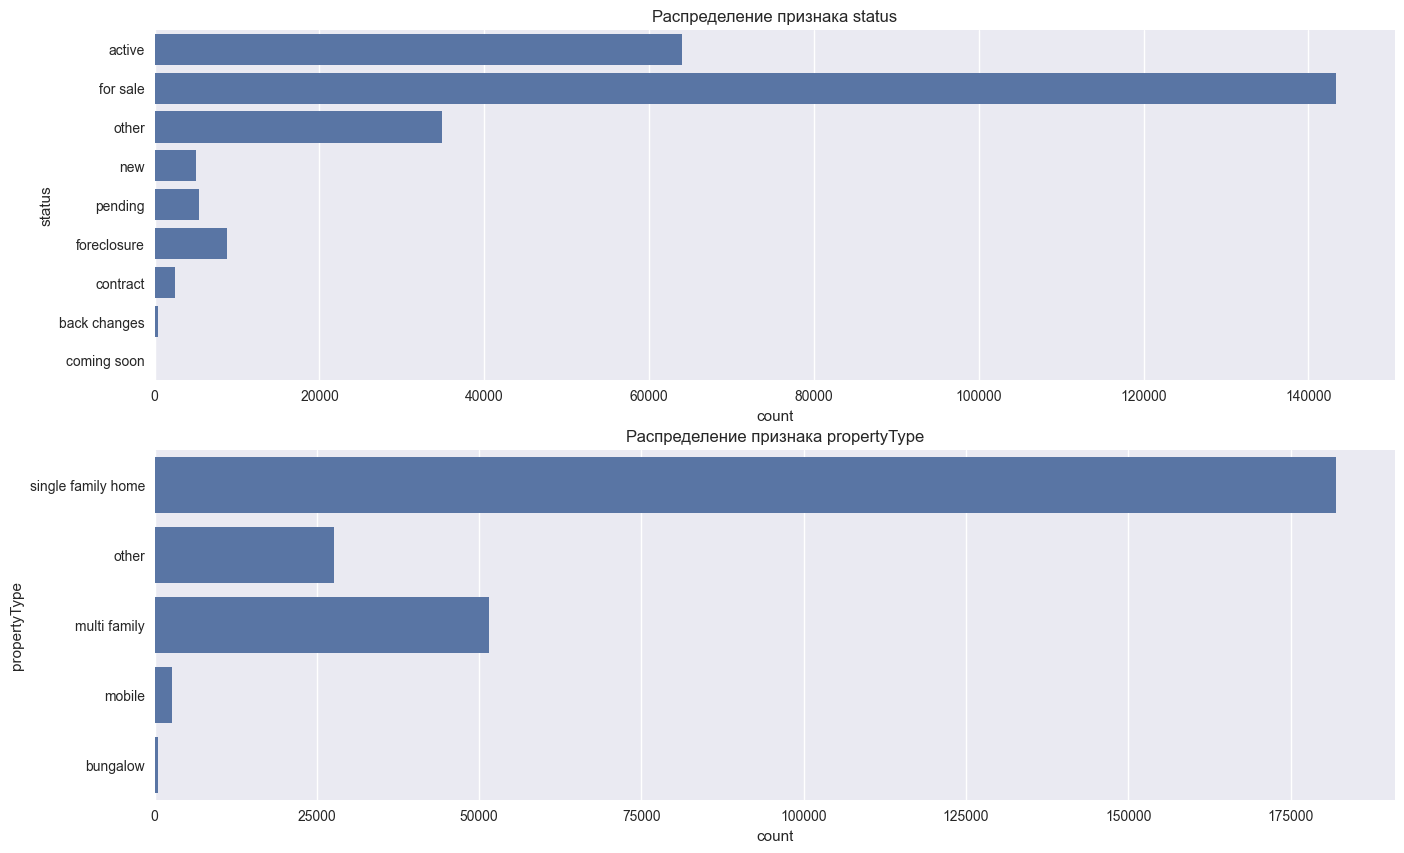

In [153]:
#Визуализируем распределения признаков
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Построили первый график
sns.countplot(data=data_cleaned, y='status', ax=axes[0])
axes[0].set_title('Распределение признака status')
#Построили второй график
sns.countplot(data=data_cleaned, y='propertyType', ax=axes[1])
axes[1].set_title('Распределение признака propertyType')

Предобработаем признаки heating, cooling, parking и fireplace, превратим их в индикаторы со значениями 1 - есть и 0 - отсутствует.

In [154]:
def preprocessing_parking(parking):
    if parking == 'None' or parking == '0' or parking == 0:
        return 0
    else:
        return 1

data_cleaned['parking'] = data_cleaned['parking'].fillna(0).apply(preprocessing_parking)
data_cleaned['cooling'] = data_cleaned['cooling'].apply(lambda x: 1 if x else 0)
data_cleaned['heating'] = data_cleaned['heating'].apply(lambda x: 1 if x else 0)

Посмотрим на распределения получившихся признаков

Text(0.5, 1.0, 'Распределение признака propertyType')

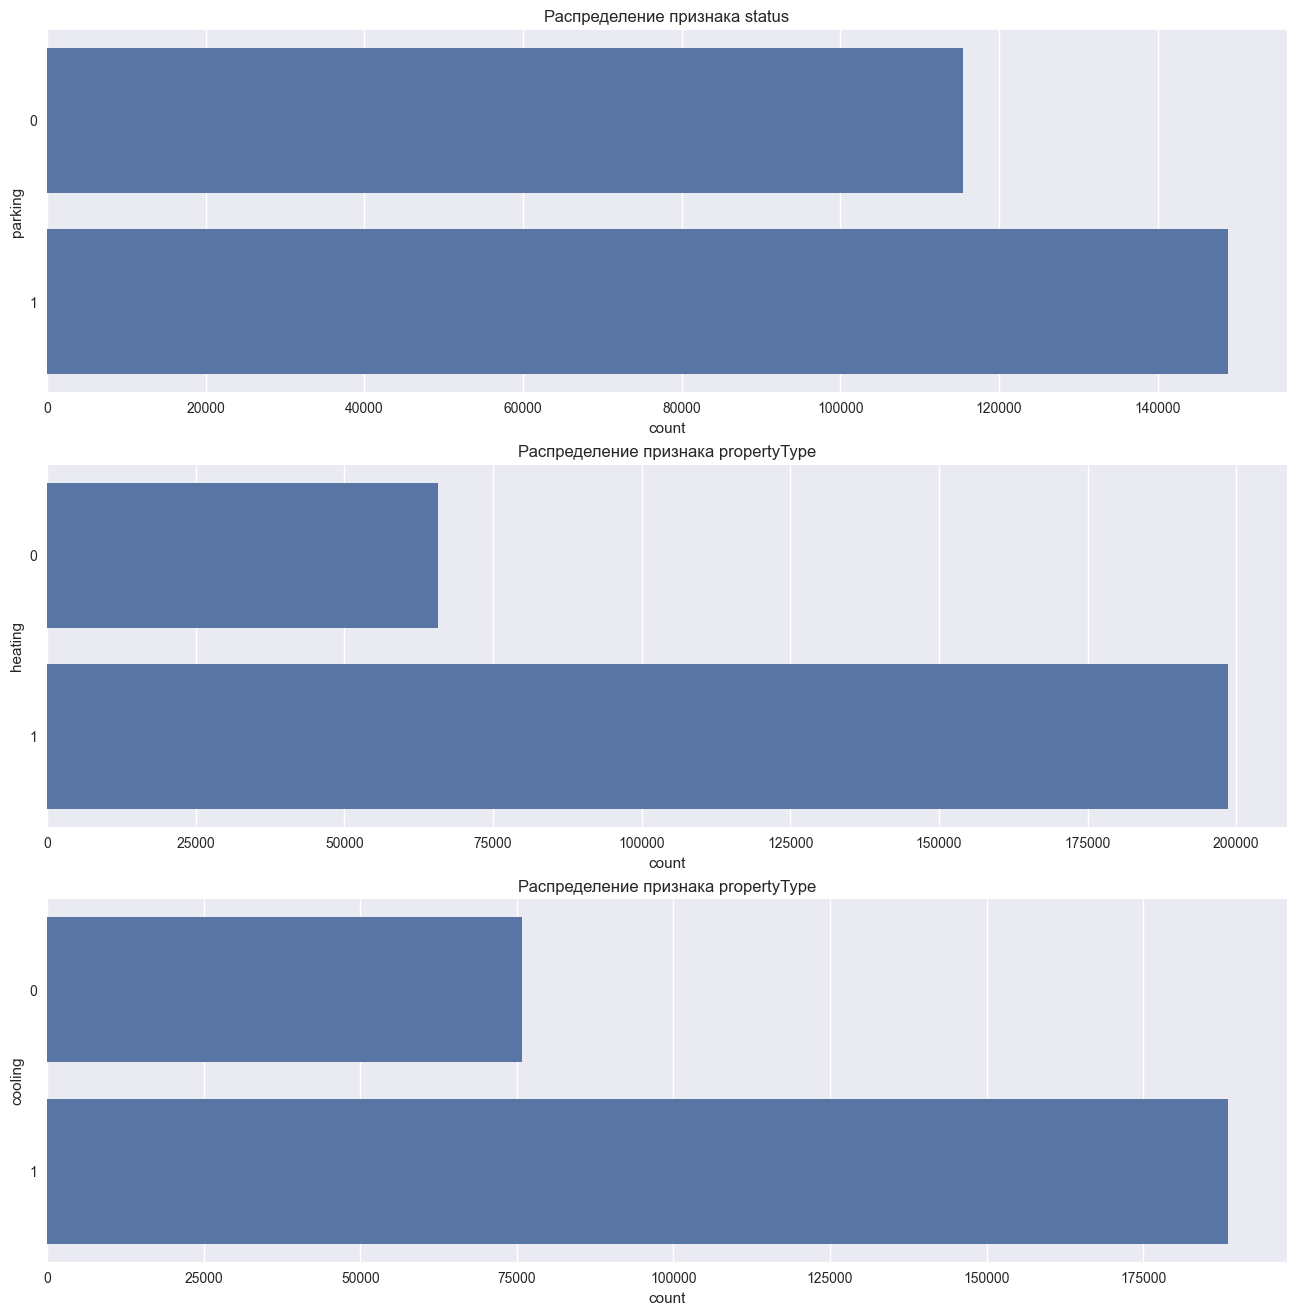

In [155]:
#Визуализируем распределения признаков
fig, axes = plt.subplots(3, 1, figsize=(16, 16))
#Построили первый график
sns.countplot(data=data_cleaned, y='parking', ax=axes[0])
axes[0].set_title('Распределение признака status')
#Построили второй график
sns.countplot(data=data_cleaned, y='heating', ax=axes[1])
axes[1].set_title('Распределение признака propertyType')
#Построили третий график
sns.countplot(data=data_cleaned, y='cooling', ax=axes[2])
axes[2].set_title('Распределение признака propertyType')

Предобработаем признак, который отвечает за количество этажей в здании.

In [156]:
def preprocessing_stories(data):
    """ 
    Функция возвращает число для столбца 'stories'.

    Она использует словарь для сопоставления слов с числами.
    Если слово найдено в словаре, возвращается соответствующее число.
    Если в строке присутствует число, оно возвращается.
    Если ничего не найдено, возвращается среднее значение.
    """

    # Словарь, сопоставляющий слова с числами
    nums = {
        'one': '1',
        'bungalow': '1',
        'two': '2',
        'traditional': '2',
        'bi-level': '2',
        'farm': '2',
        'three': '3',
        'tri': '3',
        'mid-rise': '4',
        'high-rise': '7'
    }

    # Ищем первое число в строке
    matched_num = re.match(r'\d+', data)
    # Разбиваем строку на слова и приводим их к нижнему регистру
    splitted = data.lower().split(' ')

    for i in splitted:
        # Если слово найдено в словаре, возвращаем соответствующее число
        if i in nums.keys():
            return int(nums[i])
        # Если найдено число в строке, возвращаем его
        elif matched_num:
            return int(matched_num[0])
        # Если слово состоит только из цифр, возвращаем его
        elif i.isdigit():
            return int(i)
    
    # Если ничего не найдено, возвращаем NaN
    return np.nan

# Применяем функцию к столбцу 'stories'
data_cleaned['stories'] = data_cleaned['stories'].astype(str).apply(preprocessing_stories)

# Заполняем пропуски средним значением
data_cleaned['stories'].fillna(data_cleaned['stories'].mean().round(), inplace=True)

Посмотрим на распределение получившегося признака.

Text(0.5, 1.0, 'Распределение признака stories')

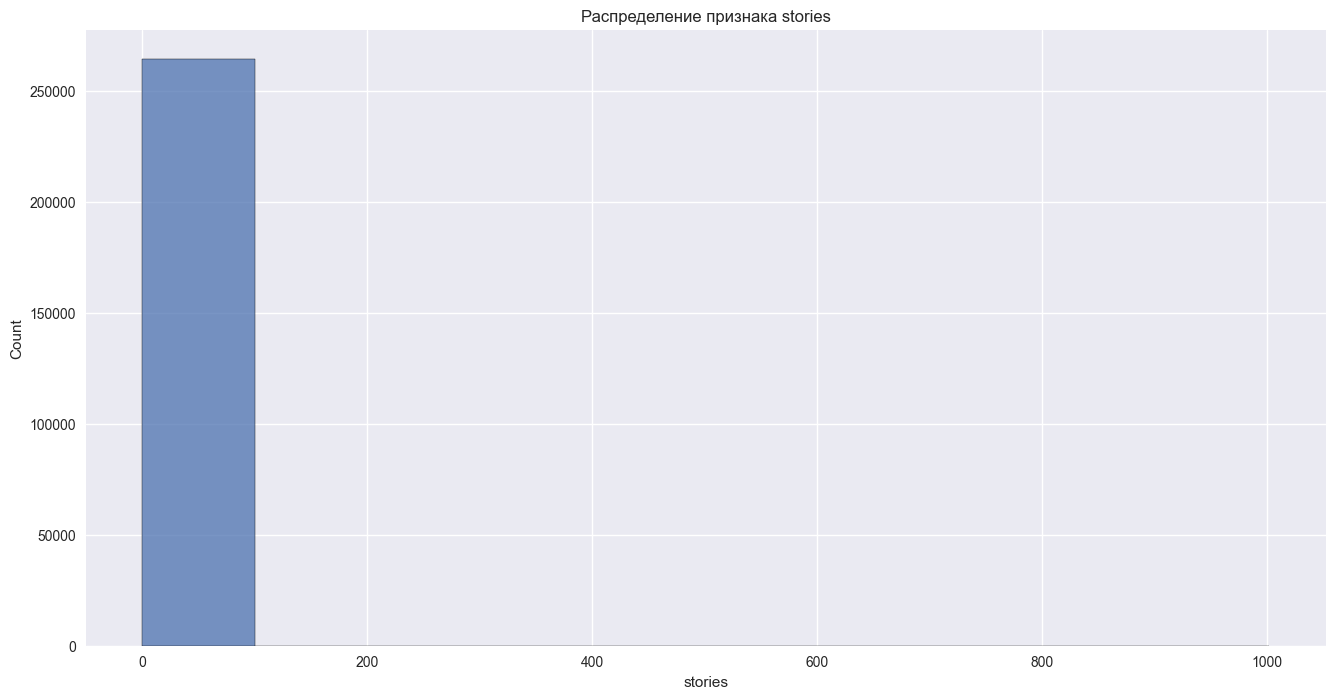

In [157]:
#Визуализируем  распределение признака
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data_cleaned, x='stories', bins=10, ax=ax)
ax.set_title('Распределение признака stories')

Видим, что в данных присутствуют аномальные значения, оставим только те, у которых этажей меньше, чем 163.

In [158]:
#Удаляем выбросы
data_cleaned = data_cleaned[data_cleaned['stories'] <= 163]

Также почистим его с помощью метода Тьюки.

Количество наблюдений после удаления выбросов: 249645


Text(0.5, 1.0, 'Распределение целевой переменной')

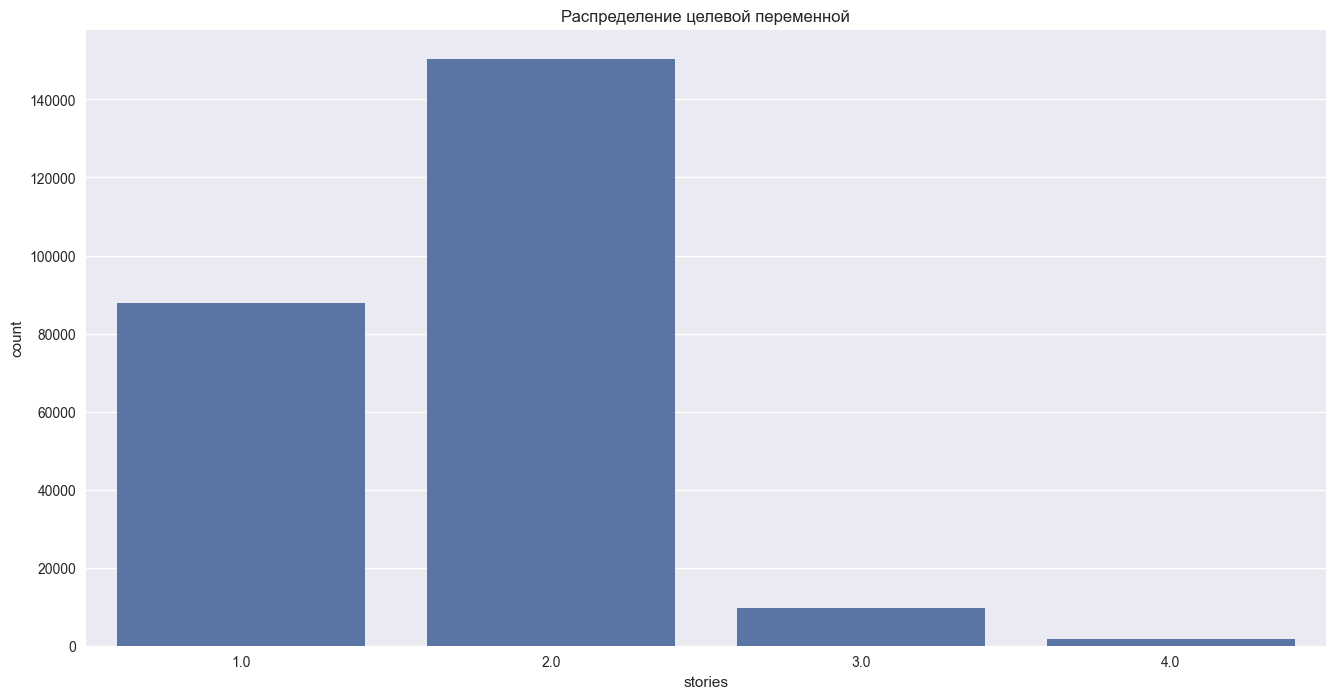

In [159]:
#Удаляем выбросы
data_cleaned = tukey_method(data_cleaned, 'stories', log_need=True)
print(f'Количество наблюдений после удаления выбросов: {data_cleaned.shape[0]}')

#Визуализируем гистограмму целевой переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data=data_cleaned, x='stories', ax=ax)
ax.set_title('Распределение целевой переменной')

Удаляим признак fireplace слишком много выбросов и малоинформативен.

In [160]:
data_cleaned = data_cleaned.drop('fireplace', axis=1)

Проверим остались ли в данных и пропуски и проверим дубликаты.

In [161]:
#Выведем количество дубликатов
print(f'Количество дубликатов: {data_cleaned.duplicated().sum()}')
#Посмотрим пропуски
data_cleaned.isnull().mean() * 100

Количество дубликатов: 1494


status                  0.000000
propertyType            0.000000
baths                   0.000000
city                    0.000000
sqft                    0.000000
beds                    0.000000
state                   0.000000
stories                 0.000000
target                  0.000000
avg_rating_schools      1.025857
avg_distance_schools    0.773899
heating                 0.000000
cooling                 0.000000
parking                 0.000000
lotsize                 0.000000
target_boxcox           0.000000
pool                    0.000000
built_age               0.000000
is_remodeled            0.000000
repair_age              0.000000
street_type             0.000000
dtype: float64

Заполняем пропуски медианным значением.

In [162]:
data_cleaned['avg_rating_schools'] = data_cleaned['avg_rating_schools'].fillna(data_cleaned['avg_rating_schools'].median())
data_cleaned['avg_distance_schools'] = data_cleaned['avg_distance_schools'].fillna(data_cleaned['avg_distance_schools'].median())

Удаляем дубликаты.

In [163]:
print(f'Количество дубликатов: {data_cleaned.duplicated().sum()}')
data_cleaned = data_cleaned.drop_duplicates()
print(f'Количество дубликатов после удаления: {data_cleaned.duplicated().sum()}')

Количество дубликатов: 1494
Количество дубликатов после удаления: 0


Проверим признаки на соответсвие типам и еще раз убедимся, что пропусков нет.

In [164]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248151 entries, 0 to 377184
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                248151 non-null  object 
 1   propertyType          248151 non-null  object 
 2   baths                 248151 non-null  int64  
 3   city                  248151 non-null  object 
 4   sqft                  248151 non-null  float64
 5   beds                  248151 non-null  float64
 6   state                 248151 non-null  object 
 7   stories               248151 non-null  float64
 8   target                248151 non-null  float64
 9   avg_rating_schools    248151 non-null  float64
 10  avg_distance_schools  248151 non-null  float64
 11  heating               248151 non-null  int64  
 12  cooling               248151 non-null  int64  
 13  parking               248151 non-null  int64  
 14  lotsize               248151 non-null  float64
 15  targe

In [165]:
#Для удобстав заменяем переменную
data = data_cleaned

> *Важно! Далее, когда я буду говорить про целевую переменную, я буду иметь ввиду ее target_boxcox.*

Давайте посмотрим влияет ли признак наличия бассейна на целевой признак. Для этого визуализируем boxplot целевого признака в разрезе признака pool.

Text(0.5, 1.0, 'Распределение target_boxcox в разрезе pool')

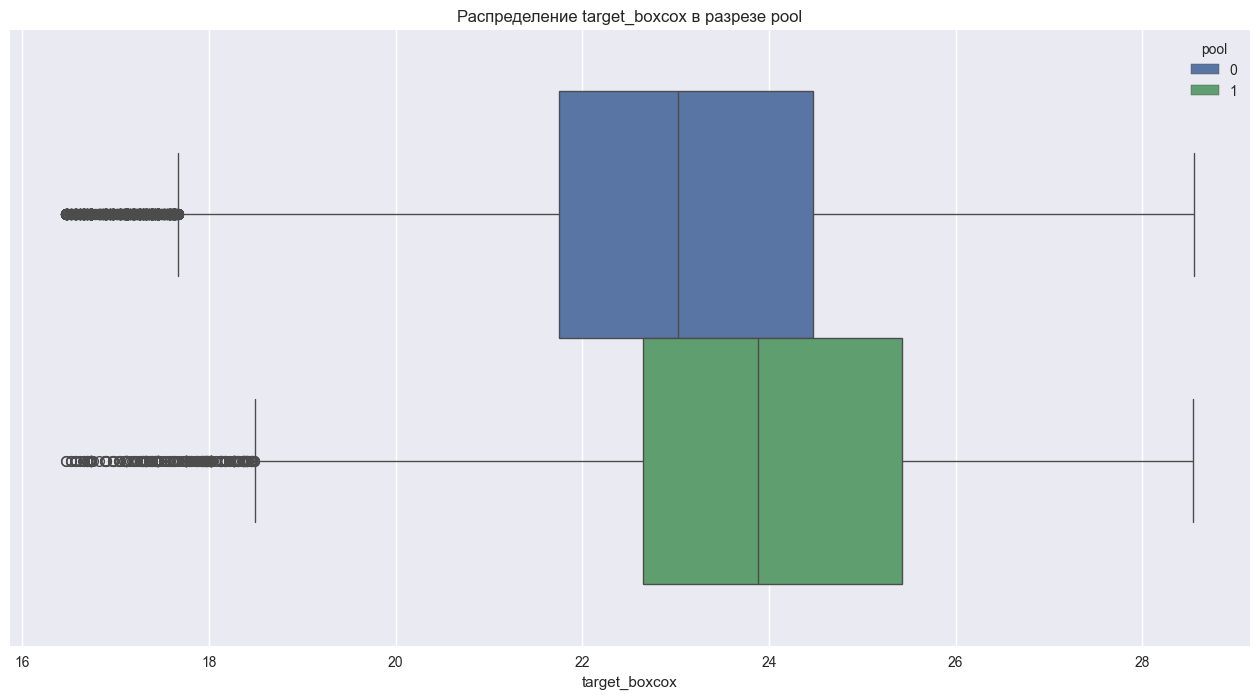

In [166]:
#Строим визуализацию.
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, x='target_boxcox', hue='pool', ax=ax)
ax.set_title('Распределение target_boxcox в разрезе pool')

Из визуализации можно сделать вывод, что недвижимость с бассейном имеет большую стоимость, чем без него, так как коробка и медианное значение данных с бассейном находится в стороне больших значений. В целом это логично, потому что бассейн и оборудование для него - дорогое удовольствие. Давайте проверим то, насколько эта разница в распределениях статистически значима, для этого проведем статистический тест.

Для начала проверим распределения на нормальность. Будем делать это с помощью теста Шапиро-Уилка.

Гипотезы в основе теста:

* Нулевая: данные распределены нормально.
* Альтернативная: данные не распределены нормально.

Сейчас и в других тестах за уровень значимости возьмем $\alpha = 0.05$

In [167]:
#Уровень значимости
alpha = 0.05
#Определяем наши выборки
data_with_pool = data[data['pool'] == 1]['target_boxcox']
data_without_pool = data[data['pool'] == 0]['target_boxcox']

print(f'Тест для выборки с бассейном')
# проводим тест Шапиро — Уилка
_, p = stats.shapiro(data_with_pool);
print('p-value = %.3f' % (p))
# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')
    
print(f'Тест для выборки без бассейна')
# проводим тест Шапиро — Уилка
_, p = stats.shapiro(data_without_pool);
print('p-value = %.3f' % (p))
# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

Тест для выборки с бассейном
p-value = 0.000
Распределение не нормальное
Тест для выборки без бассейна
p-value = 0.000
Распределение не нормальное


C:\Users\drfre\AppData\Local\Temp\ipykernel_27980\2127346276.py:9: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 28503.
  _, p = stats.shapiro(data_with_pool);
C:\Users\drfre\AppData\Local\Temp\ipykernel_27980\2127346276.py:19: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 219648.
  _, p = stats.shapiro(data_without_pool);


Так как данные распределены не нормально, будем использовать непараметрический тест - критерий Манна-Уинтни.

Гипотезы:

* Нулевая гипотеза: наличие бассейна не влияет на ценообразование недвижимости.
* Альтернативная гипотеза: наличие бассейна влияет на ценообразование недвижимости.

In [168]:
# проводим тест
_, p = stats.mannwhitneyu(data_with_pool, data_without_pool)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


По результатам нашего теста мы считаем, что бассейн влияет на цену, что соответствует нашим выводам по визуализации, так что не зря мы не удалили этот признак из-за большого числа пропусков, возможно, он будет иметь ценность для модели.

Теперь посмотрим на целевую переменную в разрезе признака количества ванных комнат.

Text(0.5, 1.0, 'Распределение target_boxcox в разрезе baths')

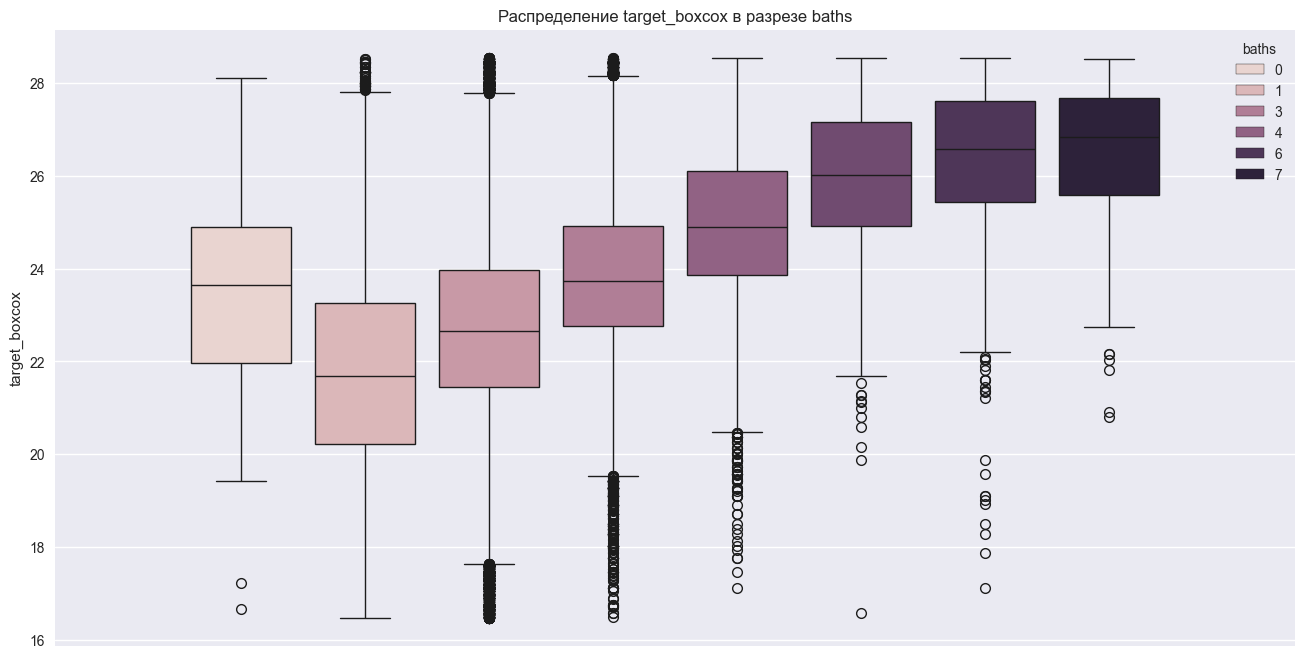

In [169]:
#Строим визуализацию.
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='target_boxcox', hue='baths', gap=.2, ax=ax)
ax.set_title('Распределение target_boxcox в разрезе baths')

Здесь сразу же прослеживается тот факт, что чем больше ванных комнат, тем больше стоимость недвижимости - опять же это логично. Смущает большое количество выбросов, но если мы вспомним распределение целевого признака, он сам по себе имел большое количество аномольных значений, поэтому это, возможно, нормально. В целом если этот фактор будет иметь большую важность при прогнозировании, а метрика будет меня не устраивать, я усилю его предобработку.

Точно также проведем статистические тесты. Для начала проверяем на нормальность.

In [170]:
#Уровень значимости
alpha = 0.05
#Определяем наши выборки
data_baths_0 = data[data['baths'] == 0]['target_boxcox']
data_baths_1 = data[data['baths'] == 1]['target_boxcox']
data_baths_2 = data[data['baths'] == 2]['target_boxcox']
data_baths_3 = data[data['baths'] == 3]['target_boxcox']
data_baths_4 = data[data['baths'] == 4]['target_boxcox']
data_baths_5 = data[data['baths'] == 5]['target_boxcox']
data_baths_6 = data[data['baths'] == 6]['target_boxcox']
data_baths_7 = data[data['baths'] == 7]['target_boxcox']

# проводим тест Шапиро — Уилка
_, p = stats.shapiro(data_baths_0);
print('p-value = %.3f' % (p))
# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

p-value = 0.079
Распределение нормальное


Так как распределение не нормальное, используем непараметрический тест критерий Краскела-Уоллиса.

Гипотезы:

* Нулевая гипотеза: кол-во ванных не влияет на ценообразование недвижимости.
* Альтернативная гипотеза: кол-во ванных влияет на ценообразование недвижимости.

In [171]:
_, p = stats.kruskal(data_baths_0, data_baths_1, data_baths_2, data_baths_3, data_baths_4, data_baths_5, data_baths_6, data_baths_7)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Итак, результат соответствует нашей визуализации - кол-во ванных комнат влияет на цену дома. 

Давайте посмотрим на распределение таргета в зависимости от других категориальных признаков.

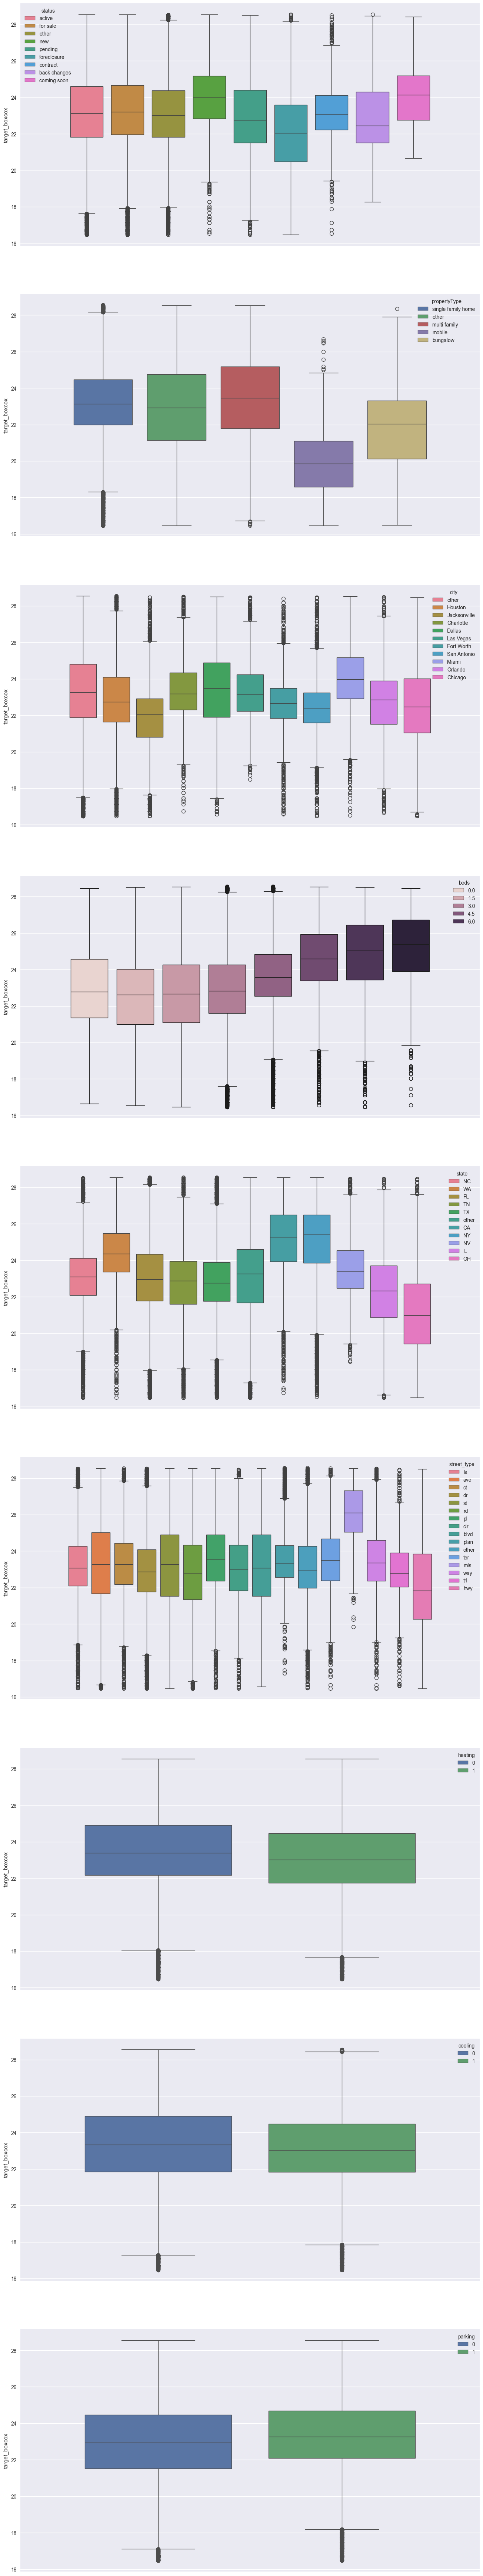

In [172]:
cat_cols = ['status', 'propertyType', 'city', 'beds', 'state', 'street_type', 'heating', 'cooling', 'parking']
#Строим графики
fig, axes = plt.subplots(len(cat_cols), 1, figsize = (16, 90))
for i, col in enumerate(cat_cols):
    sns.boxplot(data, y='target_boxcox', hue=col, gap=.2, ax=axes[i])
    ax.set_title(f'Распределение target_boxcox в разрезе {col}')

Можно сделать выводы, что признак цены зависит от города и штата сильнее, чем от других категориальных. Вероятно так происходит из-за того, что в разных местах разный уровень жизни и разная политика. Смущает фактор status, возможно он не влияет на целевую переменную, это стоит проверить.

Закодируем категориальные признаки с помощью OneHotEncoder.

In [173]:
data_pipeline = data.copy()

#Кодируем категориальные признаки
#Выбираем категориальные признаки
cat_features = data.select_dtypes(include=['object']).columns
#Создаем экземпляр BinaryEncoder
encoder = ce.OneHotEncoder(cols=cat_features, use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data[cat_features])
data = pd.concat([data, type_bin], axis=1)

#Удаляем оригинальные категориальные признаки
data.drop(cat_features, axis=1, inplace=True)
print(f'Shape of data: {data.shape}')
data.head()

Shape of data: (248151, 68)


baths    sqft  beds  stories    target  avg_rating_schools  \
0      3  2900.0   4.0      2.0  418000.0            5.200000   
1      3  1947.0   3.0      2.0  310000.0            4.000000   
6      2  1507.0   3.0      1.0  181500.0            2.333333   
7      2  1760.0   3.0      2.0   68000.0            2.666667   
9      3  1930.0   3.0      2.0  311995.0            3.000000   

   avg_distance_schools  heating  cooling  parking  ...  street_type_pl  \
0              5.537500        1        0        0  ...               0   
1              1.326667        0        0        0  ...               0   
6              3.825000        1        1        0  ...               0   
7              1.100000        0        0        0  ...               0   
9              1.066667        1        1        1  ...               0   

   street_type_cir  street_type_blvd  street_type_plan  street_type_other  \
0                0                 0                 0                  0   
1                0                 0                 0                  0   
6                0                 0                 0                  0   
7                0                 0                 0                  0   
9                0                 0                 0                  0   

   street_type_ter  street_type_mls  street_type_way  street_type_trl  \
0                0                0                0                0   
1                0                0                0                0   
6                0                0                0                0   
7                0                0                0                0   
9                0                0                0                0   

   street_type_hwy  
0                0  
1                0  
6                0  
7                0  
9                0  

[5 rows x 68 columns]

Давайте посмотрим на матрицу корреляций, удалим признаки, которые вызывают мультиколлинеарность. Будем считать такими признаки, у которых корреляция больше 0.9.

<Axes: >

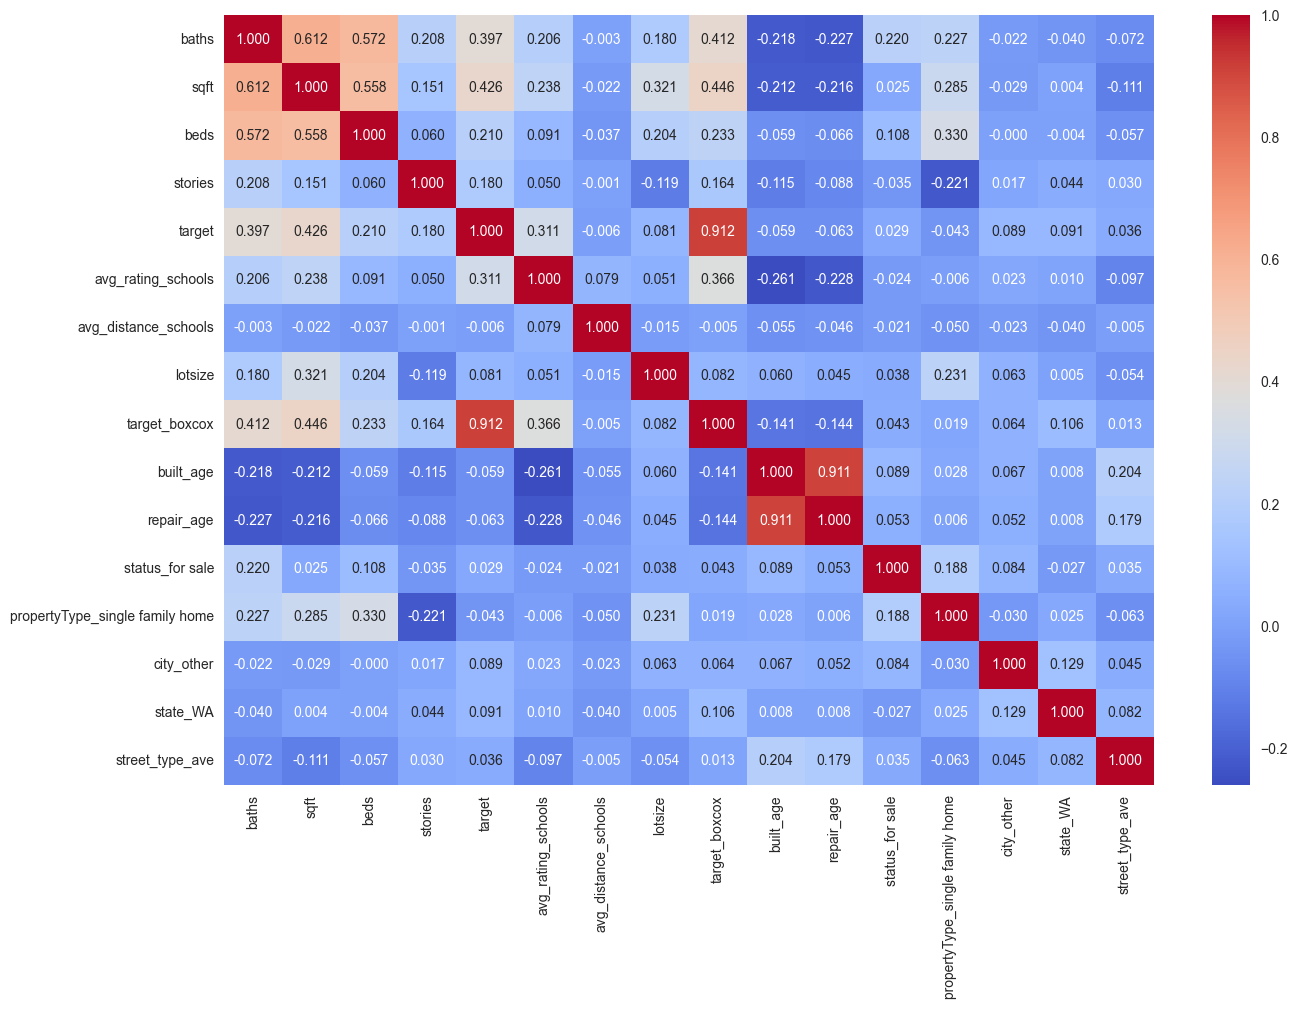

In [174]:
result_columns = []
for column in data:
    col_data = data[column]
    if col_data.min() < -0.8 or col_data.sort_values(ascending=False)[1] > 0.8:
        result_columns.append(column)
        
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data[result_columns].corr(), annot=True, cmap='coolwarm', fmt='.3f')

Удалим признак repair age, так как он вызывает мультиколлинеарность.

In [175]:
data = data.drop('repair_age', axis=1)

Давайте посмотрим на то, как зависит цена от площади здания.

Text(0.5, 1.0, 'Зависимость цены от площади')

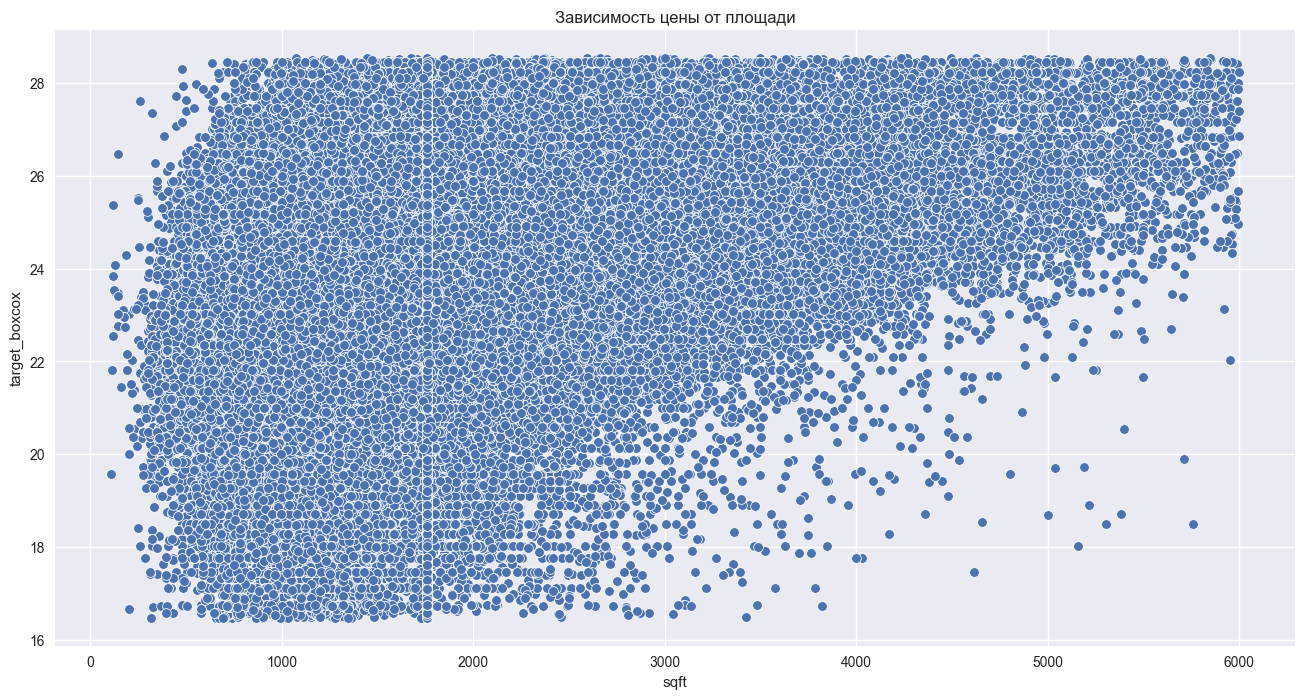

In [176]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.scatterplot(data, x='sqft', y='target_boxcox', ax=ax)
ax.set_title('Зависимость цены от площади')

Видим, что есть какая-то зависимость, но разброс очень большой. Думаю, что линейная регрессия плохо справится с этой задачей.

Давайте подведем промежуточный итог. В наших данных присутствовало много пропусков и других проблем, от пропусков избавиться здесь очень трудно и непонятно то, насколько это будет эффективно в нашем случае. Также данные имеют сложную зависимость, точно не линейную, также много категориальных признаков, поэтому могу предположить, что линейная регрессия плохо справится с этой задачей, давайте перейдем к подготовке данных к подаче в модель.

## **3. Подготовка данных**

Разделим данные на тестовую и тренировочную выборки. Будем работать с логарифмом таргета, я проверил так модель имеет лучшую метрику, оно не удивительно много выбросов в целевой переменной осталось даже после очистки, поэтому чтобы их сгладить применяем логарифм.

In [177]:
X = data.drop(['target', 'target_boxcox'], axis=1) #Матрица наблюдений
y = data['target_boxcox'] #Вектор правильных ответов
y_log = np.log(data['target_boxcox'] + 1) #Вектор правильных ответов


X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=random_seed)
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (198520, 65)
Test shape: (49631, 65)


Отберем 50 лучших признаков с помощью SelectKBest

In [178]:
#Отбор признаков с помощью SelectKBest
selector = feature_selection.SelectKBest(
    score_func = feature_selection.f_regression,
    k = 60
)
selector.fit(X_train, y_train)

# Получение индексов выбранных признаков
best_features = selector.get_feature_names_out()
X_train = X_train[best_features]
X_test = X_test[best_features]

print('Признаки, которые вошли в список отобранных:', best_features)

Признаки, которые вошли в список отобранных: ['baths' 'sqft' 'beds' 'stories' 'avg_rating_schools'
 'avg_distance_schools' 'heating' 'parking' 'lotsize' 'pool' 'built_age'
 'is_remodeled' 'status_active' 'status_for sale' 'status_other'
 'status_new' 'status_pending' 'status_foreclosure' 'status_coming soon'
 'propertyType_single family home' 'propertyType_other'
 'propertyType_multi family' 'propertyType_mobile' 'propertyType_bungalow'
 'city_other' 'city_Houston' 'city_Jacksonville' 'city_Charlotte'
 'city_Dallas' 'city_Las Vegas' 'city_Fort Worth' 'city_San Antonio'
 'city_Miami' 'city_Orlando' 'city_Chicago' 'state_NC' 'state_WA'
 'state_FL' 'state_TN' 'state_TX' 'state_other' 'state_CA' 'state_NY'
 'state_NV' 'state_IL' 'state_OH' 'street_type_la' 'street_type_ave'
 'street_type_ct' 'street_type_dr' 'street_type_st' 'street_type_rd'
 'street_type_pl' 'street_type_cir' 'street_type_plan' 'street_type_ter'
 'street_type_mls' 'street_type_way' 'street_type_trl' 'street_type_hwy']


Теперь давайте отмасштабируем данные

In [179]:
#Обучаем MinMaxScaler
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
#Нормализуем данные
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Можем приступать к обучению моделей машинного обучения

In [180]:
y_train_for_metrics = inv_boxcox(np.exp(y_train) + 1, update_price[1])
y_test_for_metrics = inv_boxcox(np.exp(y_test) + 1, update_price[1])

## **4. Построение модели**
В качестве метрик для оценки наших моделей будем использовать MAPE и MAE.

Для начала построим baseline в виде линейной регрессии, чтобы посмотреть решается ли наша задача и оценить можно ли ее решить простыми моделями.

In [181]:
#Обучаем модель
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
#Строим предсказания и выводим метрики
y_train_pred = inv_boxcox(np.exp(lr_model.predict(X_train_scaled)) + 1, update_price[1])
y_test_pred = inv_boxcox(np.exp(lr_model.predict(X_test_scaled)) + 1, update_price[1])
print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train_for_metrics, y_train_pred) * 100, 2)}')
print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test_for_metrics, y_test_pred) * 100, 2)}')
print(f'Train MAE: {round(metrics.mean_absolute_error(y_train_for_metrics, y_train_pred), 2)}')
print(f'Test MAE: {round(metrics.mean_absolute_error(y_test_for_metrics, y_test_pred), 2)}')

Train MAPE: 41.66
Test MAPE: 42.03
Train MAE: 253009.15
Test MAE: 253412.3


Давайте посмотрим на то, как с этой задачей справится дерево решений, параметры подберем с помощью RandomizedSearchCV.

In [182]:
#Модель
dt_model = DecisionTreeRegressor(random_state=random_seed)
#Сетка параметров
param_grid = {
    'max_depth': np.arange(1, 100, 10),
    'min_samples_leaf': np.arange(1, 20, 4),
}
#Подбор гиперпараметров
grid_dt = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_grid,
    cv=5,
    n_iter=10,
    verbose=2,
    n_jobs=-1
)
#Обучаем модель
grid_dt.fit(X_train_scaled, y_train)
print(f'best params: {grid_dt.best_params_}')
dt_model = grid_dt.best_estimator_
#Строим предсказания и выводим метрики
y_train_pred = inv_boxcox(np.exp(dt_model.predict(X_train_scaled)) + 1, update_price[1])
y_test_pred = inv_boxcox(np.exp(dt_model.predict(X_test_scaled)) + 1, update_price[1])
print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train_for_metrics, y_train_pred) * 100, 2)}')
print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test_for_metrics, y_test_pred) * 100, 2)}')
print(f'Train MAE: {round(metrics.mean_absolute_error(y_train_for_metrics, y_train_pred), 2)}')
print(f'Test MAE: {round(metrics.mean_absolute_error(y_test_for_metrics, y_test_pred), 2)}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best params: {'min_samples_leaf': 13, 'max_depth': 91}
Train MAPE: 24.32
Test MAPE: 31.73
Train MAE: 161213.6
Test MAE: 200679.45


Дерево решений справляется явно лучше, чем линейная регрессия, это соответствует сделаными мною ранее выводам.

Перейдем к сильным моделям. Построим случайным лес с параметрами дерева, которые получили ранее, а кол-во деревьев подберем с помощью RandomizedSearchCV.

In [183]:
#Модель
rf_model = RandomForestRegressor(min_samples_leaf=17, max_depth=71, random_state=random_seed)
#Сетка параметров
param_grid = {
    'n_estimators': np.arange(100, 301, 100)
}
#Подбор гиперпараметров
grid_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    cv=2,
    n_iter=3,
    verbose=2,
    n_jobs=-1
)
#Обучаем модель
grid_rf.fit(X_train_scaled, y_train)
print(f'best params: {grid_rf.best_params_}')
rf_model = grid_rf.best_estimator_
#Строим предсказания и выводим метрики 
y_train_pred = inv_boxcox(np.exp(rf_model.predict(X_train_scaled)) + 1, update_price[1])
y_test_pred = inv_boxcox(np.exp(rf_model.predict(X_test_scaled)) + 1, update_price[1])
print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train_for_metrics, y_train_pred) * 100, 2)}')
print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test_for_metrics, y_test_pred) * 100, 2)}')
print(f'Train MAE: {round(metrics.mean_absolute_error(y_train_for_metrics, y_train_pred), 2)}')
print(f'Test MAE: {round(metrics.mean_absolute_error(y_test_for_metrics, y_test_pred), 2)}')

Fitting 2 folds for each of 3 candidates, totalling 6 fits
best params: {'n_estimators': 300}
Train MAPE: 24.45
Test MAPE: 28.29
Train MAE: 163305.73
Test MAE: 183853.82


Видим, что метрика стала еще лучше.

Давайте воспользуемся моделями бустинга, а именно реализациями из XGBoost и Catboost. Параметры будем подбирать с помощью Optuna.

In [184]:
# Реализация функции оптимизации гиперпараметров с помощью Optuna
def optuna_XGB(trial):
    # Задаем пространство поиска гиперпараметров
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 5)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    gamma = trial.suggest_float('gamma', 0.0, 0.5)

    # Создаем модель
    opt_model = xgb.XGBRegressor(
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        learning_rate=learning_rate,
        gamma=gamma,
        random_state=random_seed,
        objective='reg:squarederror')  # Указываем objective для регрессии

    # Обучаем модель
    opt_model.fit(X_train_scaled, y_train)
  
    # Воспользуемся метрикой MSE для поиска лучших гиперпараметров 
    y_train_pred = opt_model.predict(X_train_scaled)
    score = metrics.mean_squared_error(y_train, y_train_pred)

    return score

# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=random_seed)
study = optuna.create_study(
    sampler=sampler, study_name='XGBRegressor', direction='minimize')  # Направление 'minimize' для минимизации MSE
study.optimize(optuna_XGB, n_trials=20)

print(f'Лучшие параметры:\n{study.best_params}')

[I 2024-05-04 02:03:30,508] A new study created in memory with name: XGBRegressor
[I 2024-05-04 02:03:31,351] Trial 0 finished with value: 0.003310495309179102 and parameters: {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'learning_rate': 0.055245405728306586, 'gamma': 0.07799726016810132}. Best is trial 0 with value: 0.003310495309179102.
[I 2024-05-04 02:03:32,001] Trial 1 finished with value: 0.006026180606003614 and parameters: {'max_depth': 2, 'min_child_weight': 5, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'learning_rate': 0.01596950334578271, 'gamma': 0.48495492608099716}. Best is trial 0 with value: 0.003310495309179102.
[I 2024-05-04 02:03:32,860] Trial 2 finished with value: 0.0029917967562706296 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'learning_rate': 0.09823025045826593, 'gamma': 0.26237821

Лучшие параметры:
{'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.7039593671079457, 'colsample_bytree': 0.6838472792775279, 'learning_rate': 0.21006822277141066, 'gamma': 0.0021088957454742452}


Обучаем модель с полученными гиперпараметрами.

In [185]:
xgb_model  = xgb.XGBRegressor(
    learning_rate=0.21, # темп обучения
    max_depth=10, # Максимальная глубина каждого дерева
    min_child_weight=3, # Минимальное количество объектов в листовой вершине
    gamma=0.0021, # Минимальное уменьшение функции потерь, необходимое для разделения дерева
    colsample_bytree=0.68, # Доля признаков, используемых при построении каждого дерева
    subsample=0.704, # Доля обучающих данных, используемых для обучения каждого дерева
    random_state=random_seed # генератор случайных чисел
)
#Обучаем модель
xgb_model.fit(X_train_scaled, y_train)

#Строим предсказания и выводим метрики
y_train_pred = inv_boxcox(np.exp(xgb_model.predict(X_train_scaled)) + 1, update_price[1])
y_test_pred = inv_boxcox(np.exp(xgb_model.predict(X_test_scaled)) + 1, update_price[1])
print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train_for_metrics, y_train_pred) * 100, 2)}')
print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test_for_metrics, y_test_pred) * 100, 2)}')
print(f'Train MAE: {round(metrics.mean_absolute_error(y_train_for_metrics, y_train_pred), 2)}')
print(f'Test MAE: {round(metrics.mean_absolute_error(y_test_for_metrics, y_test_pred), 2)}')

Train MAPE: 20.65
Test MAPE: 25.57
Train MAE: 141481.01
Test MAE: 169229.29


Отлично! Метрики стали еще лучше, посмотрим, как справится catboost.

In [186]:
def cat_reg(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    
    opt_model = catboost.CatBoostRegressor(**params, random_state=42, silent=True)
    # Обучаем модель 
    opt_model.fit(X_train_scaled, y_train)
    # Воспользуемся метрикой MSE для поиска лучших гиперпараметров 
    y_train_pred = opt_model.predict(X_train_scaled)
    score = metrics.mean_squared_error(y_train, y_train_pred)

    return score
    
    
# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    sampler=sampler, study_name='CatBoostRegressor', direction='minimize')  # Направление 'minimize' для минимизации MSE
study.optimize(cat_reg, n_trials=50)

print(f'Лучшие параметры:\n{study.best_params}')

[I 2024-05-04 02:03:53,394] A new study created in memory with name: CatBoostRegressor
[I 2024-05-04 02:04:25,028] Trial 0 finished with value: 0.0029632960143626264 and parameters: {'learning_rate': 0.005611516415334507, 'depth': 10, 'subsample': 0.7453942447208348, 'colsample_bylevel': 0.6187255599871848, 'min_data_in_leaf': 16}. Best is trial 0 with value: 0.0029632960143626264.
[I 2024-05-04 02:04:31,513] Trial 1 finished with value: 0.0066776356627848785 and parameters: {'learning_rate': 0.002051110418843397, 'depth': 1, 'subsample': 0.8728673384861885, 'colsample_bylevel': 0.6210592611560484, 'min_data_in_leaf': 71}. Best is trial 0 with value: 0.0029632960143626264.
[I 2024-05-04 02:04:59,622] Trial 2 finished with value: 0.004908339745433462 and parameters: {'learning_rate': 0.0010994335574766201, 'depth': 10, 'subsample': 0.8408205087604007, 'colsample_bylevel': 0.25172215514436236, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.0029632960143626264.
[I 2024-05-04 02:05

Лучшие параметры:
{'learning_rate': 0.09988379436868199, 'depth': 10, 'subsample': 0.9308669964516816, 'colsample_bylevel': 0.6810728637361781, 'min_data_in_leaf': 94}


In [191]:
cat_model = catboost.CatBoostRegressor(
    iterations=1000,
    learning_rate=0.09988379436868199,
    depth=10,
    subsample=0.9308669964516816,
    colsample_bylevel=0.6810728637361781,
    min_data_in_leaf=94
)
# Обучаем модель 
cat_model.fit(X_train_scaled, y_train)

#Строим предсказания и выводим метрики
y_train_pred = inv_boxcox(np.exp(cat_model.predict(X_train_scaled)) + 1, update_price[1])
y_test_pred = inv_boxcox(np.exp(cat_model.predict(X_test_scaled)) + 1, update_price[1])
print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train_for_metrics, y_train_pred) * 100, 2)}')
print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test_for_metrics, y_test_pred) * 100, 2)}')
print(f'Train MAE: {round(metrics.mean_absolute_error(y_train_for_metrics, y_train_pred), 2)}')
print(f'Test MAE: {round(metrics.mean_absolute_error(y_test_for_metrics, y_test_pred), 2)}')

0:	learn: 0.0894242	total: 31.2ms	remaining: 31.2s
1:	learn: 0.0859115	total: 58ms	remaining: 28.9s
2:	learn: 0.0829178	total: 82.7ms	remaining: 27.5s
3:	learn: 0.0803768	total: 108ms	remaining: 27s
4:	learn: 0.0781053	total: 135ms	remaining: 26.8s
5:	learn: 0.0762371	total: 166ms	remaining: 27.4s
6:	learn: 0.0744359	total: 193ms	remaining: 27.3s
7:	learn: 0.0728407	total: 223ms	remaining: 27.7s
8:	learn: 0.0714064	total: 252ms	remaining: 27.7s
9:	learn: 0.0701818	total: 282ms	remaining: 28s
10:	learn: 0.0690487	total: 313ms	remaining: 28.1s
11:	learn: 0.0679763	total: 342ms	remaining: 28.2s
12:	learn: 0.0670417	total: 372ms	remaining: 28.2s
13:	learn: 0.0661976	total: 399ms	remaining: 28.1s
14:	learn: 0.0654210	total: 428ms	remaining: 28.1s
15:	learn: 0.0646455	total: 456ms	remaining: 28.1s
16:	learn: 0.0639805	total: 486ms	remaining: 28.1s
17:	learn: 0.0634339	total: 511ms	remaining: 27.9s
18:	learn: 0.0629138	total: 540ms	remaining: 27.9s
19:	learn: 0.0624462	total: 569ms	remaining:

Посмотрим на значимость признаков.

<Axes: xlabel='importance', ylabel='feature'>

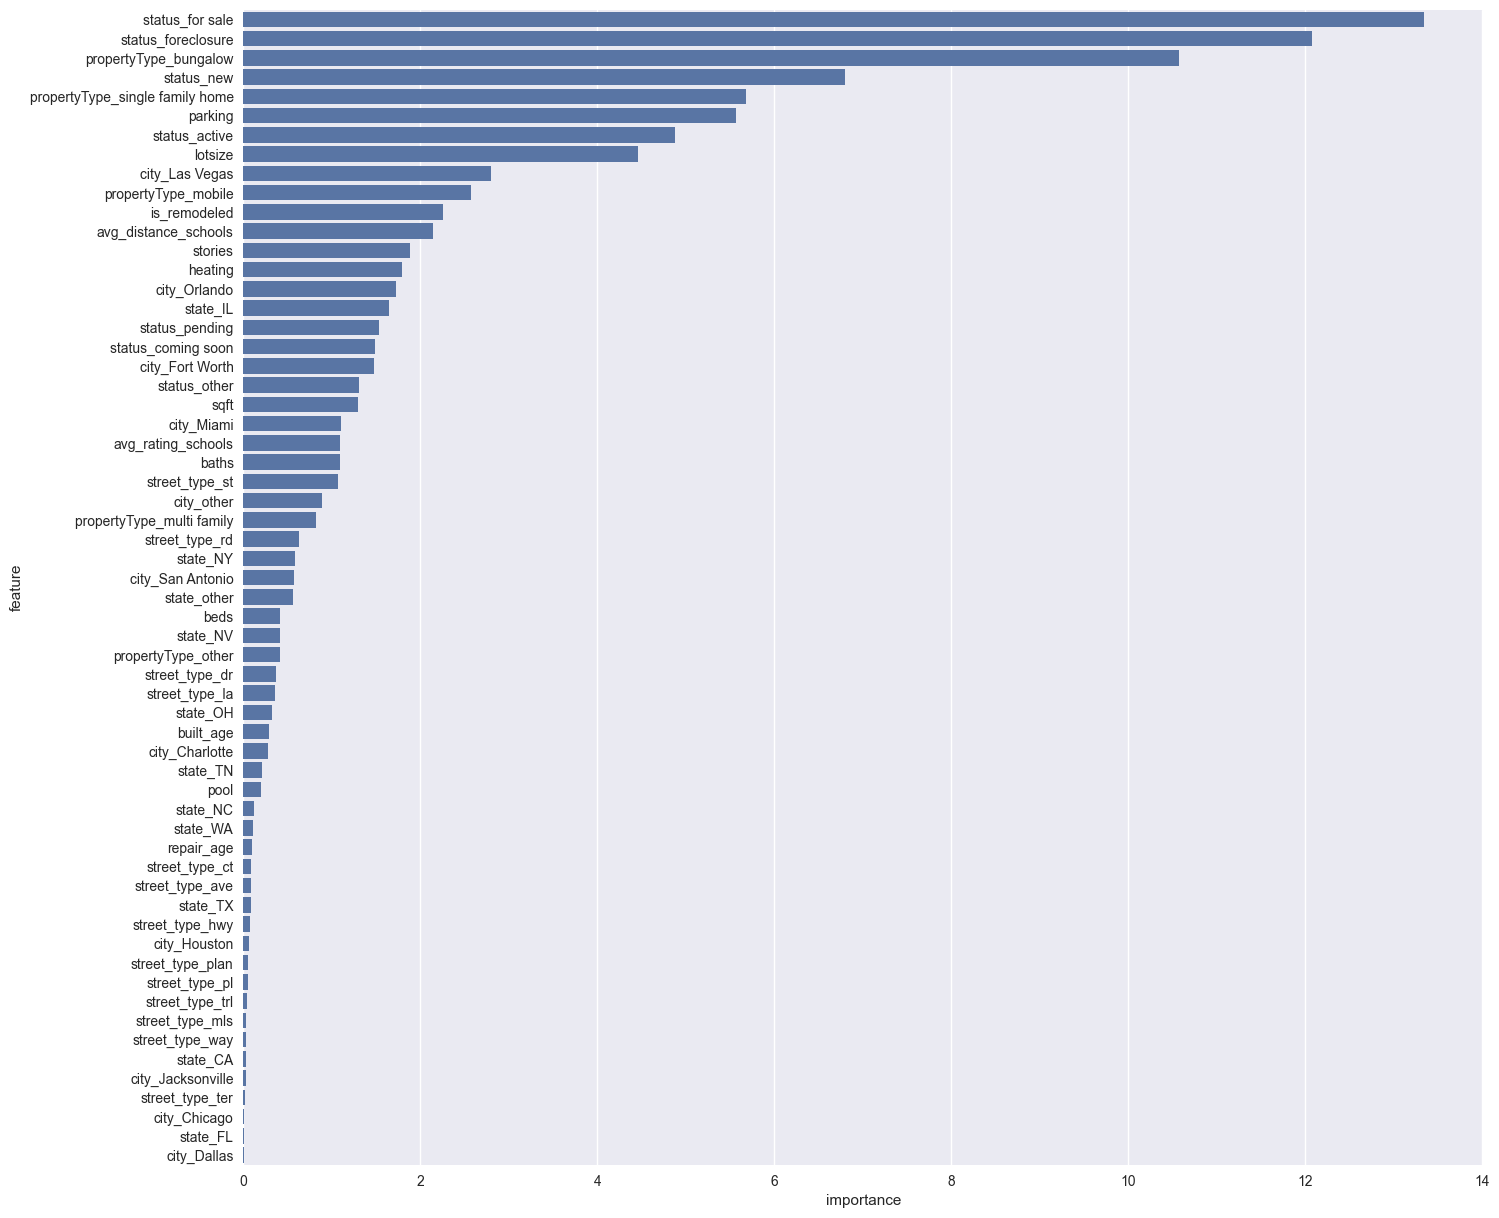

In [192]:
features_imp = pd.DataFrame(np.array([selector.get_feature_names_out(),cat_model.feature_importances_]).T, columns=['feature', 'importance'])
features_imp = features_imp.sort_values('importance', ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(16,15))
sns.barplot(features_imp, x='importance', y='feature')

Лучшую метрику показывает catboost, буду использовать ее для вывода в продакшн.

## Подготовка модели к продакшену (построение пайплайна)

Пайплайн будет состоять из следующих шагов:
1. Кодировщик категориальных признаков
2. Отбор признаков
3. Стандартизация признаков
4. Сама модель

In [193]:
X = data_pipeline.drop(['target', 'target_boxcox'], axis=1) #Матрица наблюдений
y = data_pipeline['target_boxcox'] #Вектор правильных ответов
y_log = np.log(data_pipeline['target_boxcox'] + 1) #Вектор правильных ответов

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=random_seed)

#Строим pipeline
pipeline = Pipeline(
    [('encoder', encoder),
     ('selector', selector),
     ('scaler', scaler),
     ('model', cat_model)]
)
#Обучаем pipeline
pipeline.fit(X_train, y_train)

#Строим предсказания и выводим метрики
y_train_pred = inv_boxcox(np.exp(pipeline.predict(X_train)) + 1, update_price[1])
y_test_pred = inv_boxcox(np.exp(pipeline.predict(X_test)) + 1, update_price[1])
print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train_for_metrics, y_train_pred) * 100, 2)}')
print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test_for_metrics, y_test_pred) * 100, 2)}')
print(f'Train MAE: {round(metrics.mean_absolute_error(y_train_for_metrics, y_train_pred), 2)}')
print(f'Test MAE: {round(metrics.mean_absolute_error(y_test_for_metrics, y_test_pred), 2)}')

0:	learn: 0.0894155	total: 33.5ms	remaining: 33.5s
1:	learn: 0.0859487	total: 61.7ms	remaining: 30.8s
2:	learn: 0.0829075	total: 89.8ms	remaining: 29.8s
3:	learn: 0.0803365	total: 116ms	remaining: 28.8s
4:	learn: 0.0780162	total: 143ms	remaining: 28.5s
5:	learn: 0.0759780	total: 171ms	remaining: 28.3s
6:	learn: 0.0741668	total: 201ms	remaining: 28.5s
7:	learn: 0.0725847	total: 230ms	remaining: 28.5s
8:	learn: 0.0711541	total: 258ms	remaining: 28.4s
9:	learn: 0.0699449	total: 288ms	remaining: 28.5s
10:	learn: 0.0688165	total: 318ms	remaining: 28.6s
11:	learn: 0.0677887	total: 348ms	remaining: 28.7s
12:	learn: 0.0669668	total: 379ms	remaining: 28.8s
13:	learn: 0.0661378	total: 410ms	remaining: 28.9s
14:	learn: 0.0653950	total: 445ms	remaining: 29.2s
15:	learn: 0.0646425	total: 477ms	remaining: 29.4s
16:	learn: 0.0640296	total: 508ms	remaining: 29.4s
17:	learn: 0.0634885	total: 541ms	remaining: 29.5s
18:	learn: 0.0629733	total: 572ms	remaining: 29.5s
19:	learn: 0.0624624	total: 605ms	rema

Сериализуем полученный pipeline.

In [194]:
joblib.dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']